# 泰坦尼克号生还预测

本次实验进一步熟悉机器学习的相关实践，完成数据导入、清晰、分析、训练、预测等系列环节
主要内容包括
1. 学习数据预处理，包括数据清洗、缺失值处理和分割的相关方法
2. 进一步掌握机器学习分类任务的处理，掌握决策树和逻辑回归的建模方法。

# 数据集
泰坦尼克号的数据集包括了1309行乘客数据(含训练集和测试集)，每一行数据有12列，其中11列是乘客信息，一列表示乘客是否生还，是我们预测的目标。

这里对部分字段进行说明
- Cabin：乘客的客舱号
- Embarked： 乘客的登船港
- Fare：乘客支付的票价
- Parch： 一起上船的父母和子女个数
- Pclass：乘客的社会阶层 (1上层，2中层，3底层)
- SibSp： 一起上船的兄弟姐妹和配偶个数
- Ticket：乘客的船票号
- Surviced： 生还情况（1表示生还，0表示未生还）

In [1]:
### 基础导包
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
!pip install --upgrade bottleneck

In [4]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/5e/23/f8b28ca248bb629b9e08f877dd2965d1994e1674a03d67cd10c5246da248/lightgbm-4.6.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 262.6 kB/s eta 0:00:06
   - -------------------------------------- 0.1/1.5 MB 363.1 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/1.5 MB 525.1 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.5 MB 568.9 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.5 MB 692.9 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.5 MB 692.9 kB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.5 MB 827.2 kB/s eta 0:00:02
   --------- ---------------------------

In [3]:
### 模型导包
import lightgbm as lgb
from sklearn.metrics import accuracy_score 

In [4]:
### 基础设置
pd.set_option('display.float_format',lambda x: '%.2f'%x)
pd.set_option('display.expand_frame_repr',False)
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
#pd.set_option('display.max_rows', None)
pd.set_eng_float_format(accuracy=1, use_eng_prefix=True)

# 1. EDA 数据探索
数据探索是机器学习领域最重要的概念之一。这里我们的工作包括
1. 查明宽表的各段取值含义，范围，数据结构等
2. 结合标签，分析特征的分布状态
3. 训练集与测试集是否同分布
4. 挖掘特征之间的关联

In [6]:
train = pd.read_csv("work/train.csv")
test  = pd.read_csv("work/test.csv")

### 1.1初步观察到每一个字段的类型和范围

In [7]:
train.head()

PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket  Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.3   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0   NaN        S

In [8]:
test.head()

PassengerId  Pclass                                          Name     Sex   Age  SibSp  Parch   Ticket  Fare Cabin Embarked
0          892       3                              Kelly, Mr. James    male  34.5      0      0   330911   7.8   NaN        Q
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   363272   7.0   NaN        S
2          894       2                     Myles, Mr. Thomas Francis    male  62.0      0      0   240276   9.7   NaN        Q
3          895       3                              Wirz, Mr. Albert    male  27.0      0      0   315154   8.7   NaN        S
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1  3101298  12.3   NaN        S

In [9]:
train.describe()

PassengerId  Survived  Pclass     Age   SibSp   Parch   Fare
count        891.0     891.0   891.0   714.0   891.0   891.0  891.0
mean         446.0    383.8m     2.3    29.7  523.0m  381.6m   32.2
std          257.4    486.6m  836.1m    14.5     1.1  806.1m   49.7
min            1.0       0.0     1.0  420.0m     0.0     0.0    0.0
25%          223.5       0.0     2.0    20.1     0.0     0.0    7.9
50%          446.0       0.0     3.0    28.0     0.0     0.0   14.5
75%          668.5       1.0     3.0    38.0     1.0     0.0   31.0
max          891.0       1.0     3.0    80.0     8.0     6.0  512.3

In [11]:
test.describe()

PassengerId  Pclass     Age   SibSp   Parch   Fare
count        418.0   418.0   332.0   418.0   418.0  417.0
mean          1.1k     2.3    30.3  447.4m  392.3m   35.6
std          120.8  841.8m    14.2  896.8m  981.4m   55.9
min          892.0     1.0  170.0m     0.0     0.0    0.0
25%          996.2     1.0    21.0     0.0     0.0    7.9
50%           1.1k     3.0    27.0     0.0     0.0   14.5
75%           1.2k     3.0    39.0     1.0     0.0   31.5
max           1.3k     3.0    76.0     8.0     9.0  512.3

### 1.2 查明训练集和测试集是否服从相同的分布

In [12]:
features = list(train.columns)
features.remove('Survived')

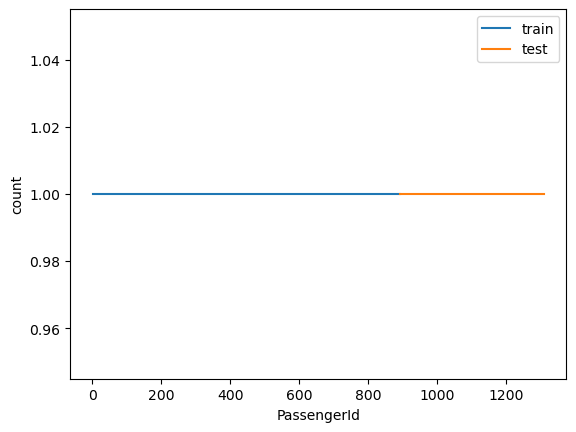

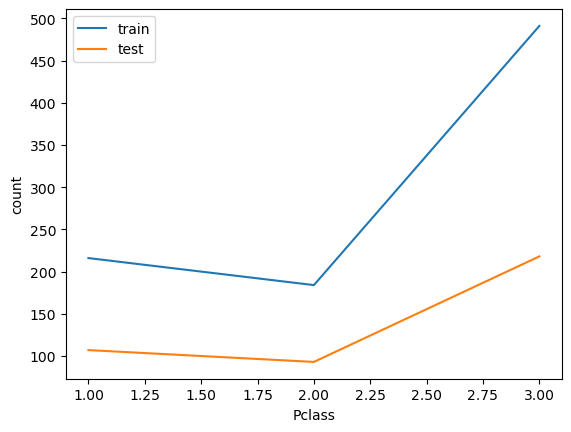

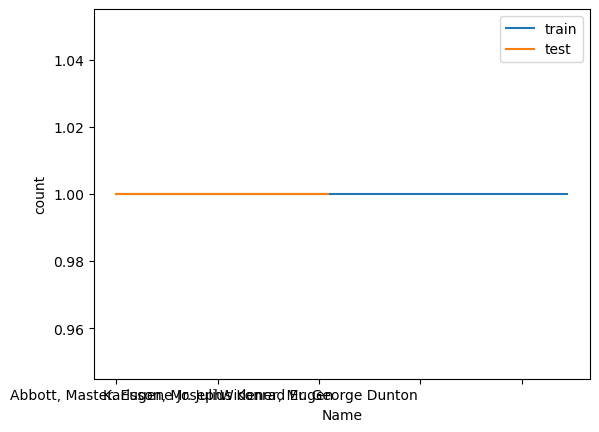

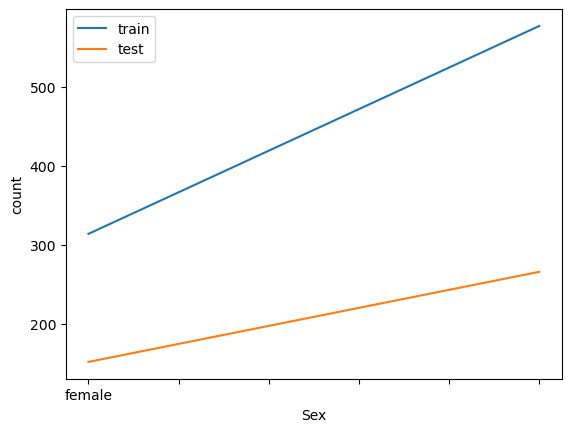

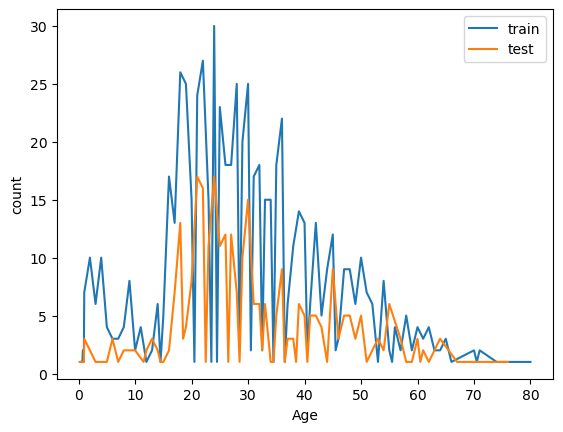

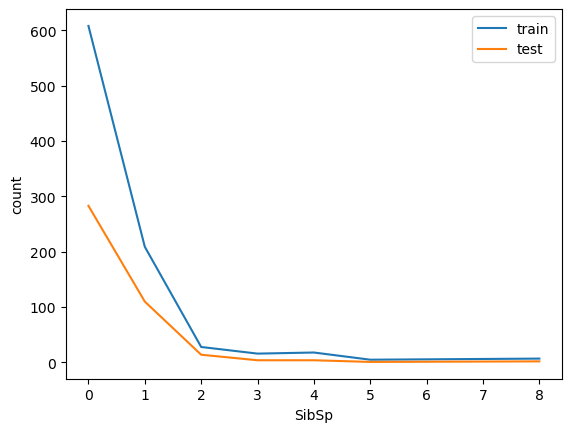

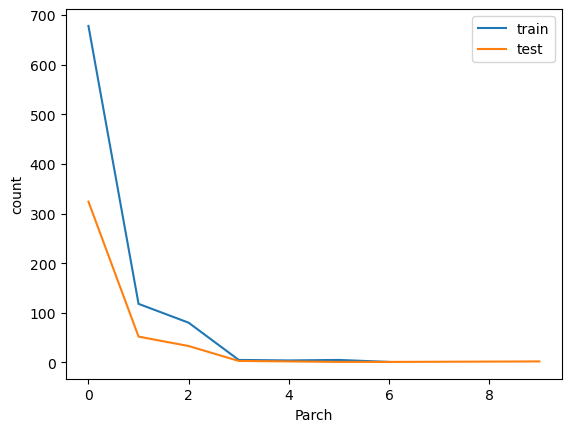

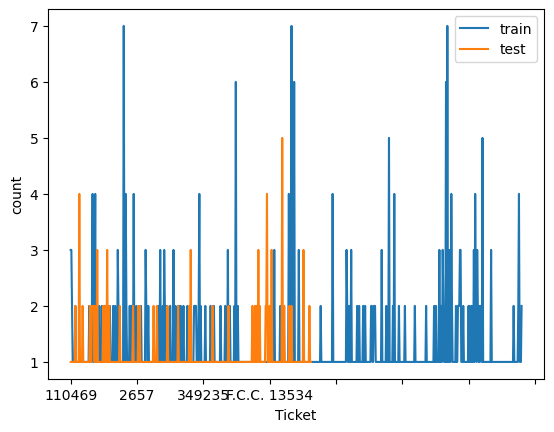

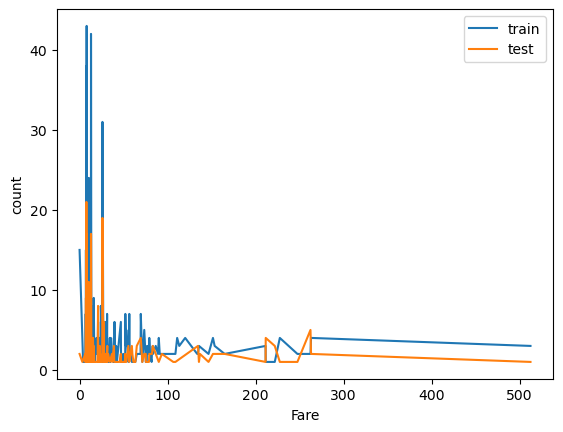

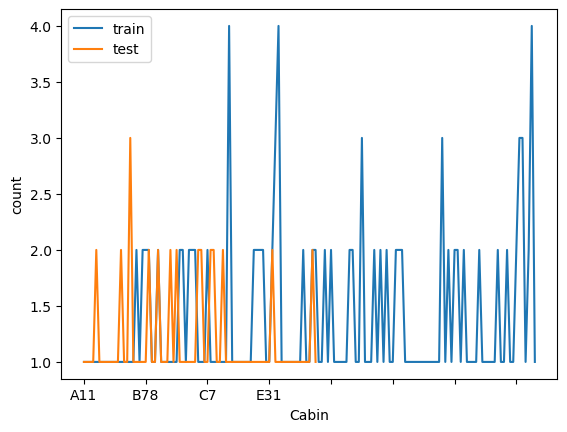

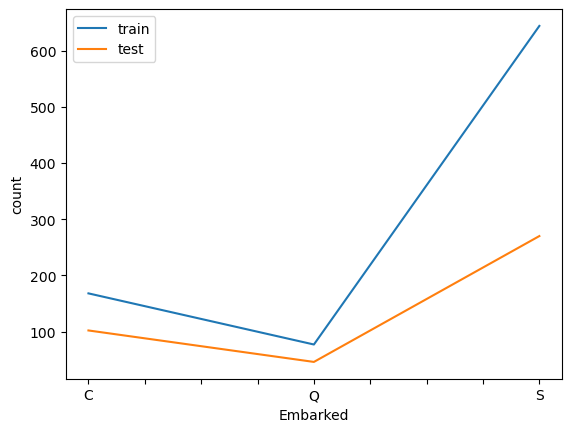

In [14]:
### 通过count定性查看
for feature in features:  # 对每一个特征进行枚举
    train[feature].value_counts().sort_index().plot()
    test[feature].value_counts().sort_index().plot()
    plt.xlabel(feature)
    plt.legend(['train','test'])
    plt.ylabel('count')
    plt.show()

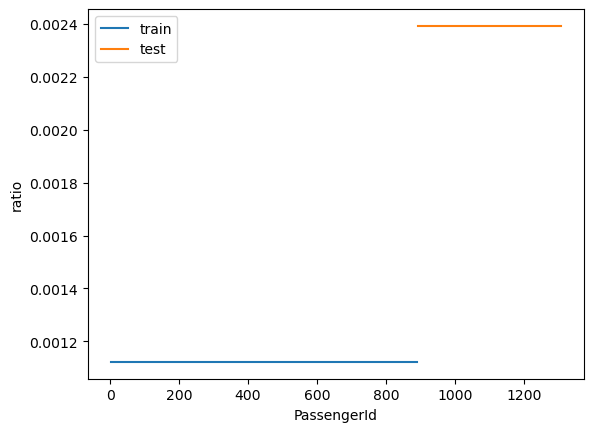

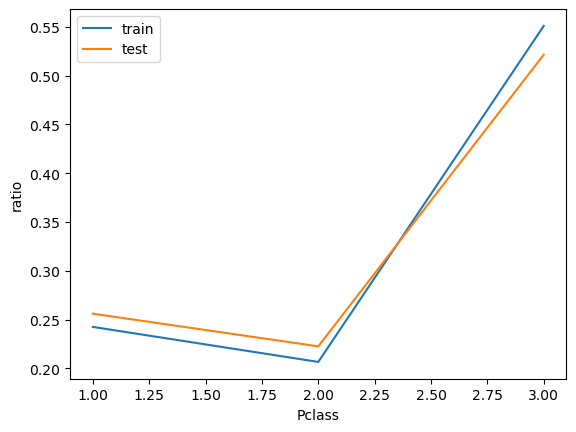

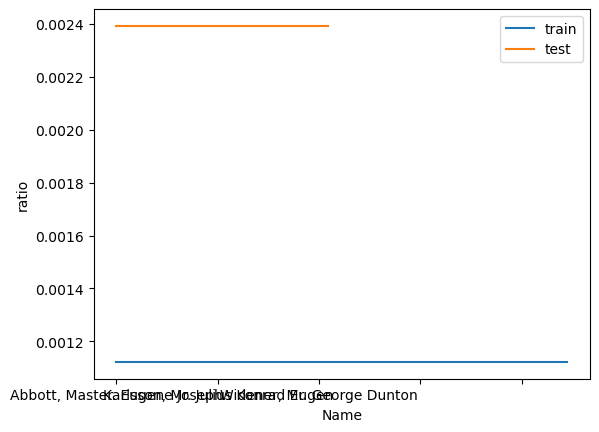

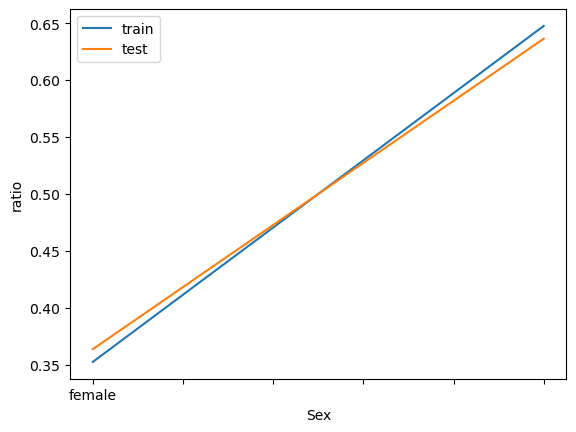

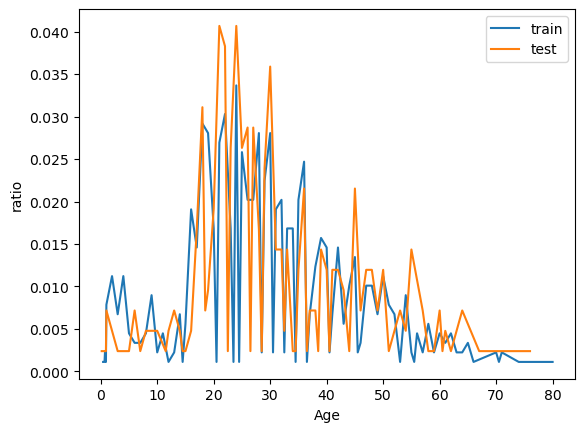

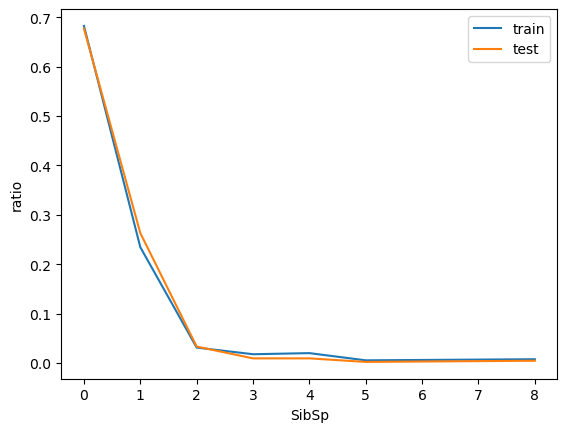

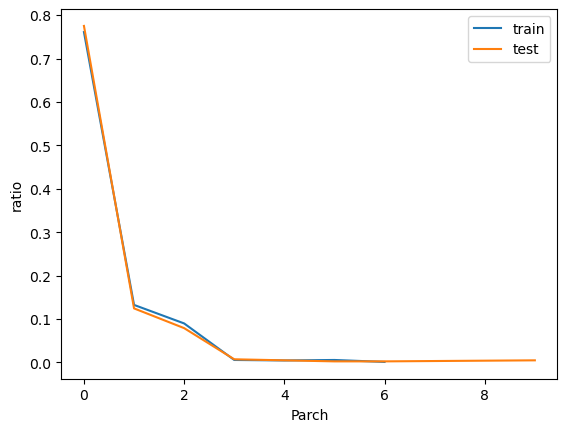

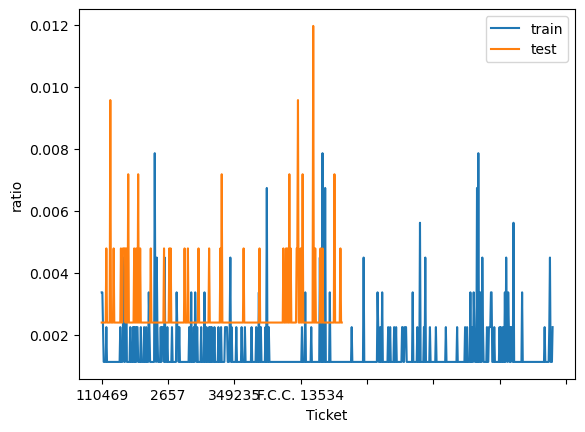

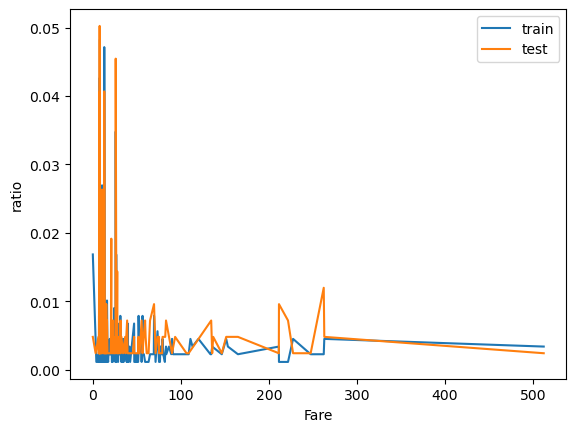

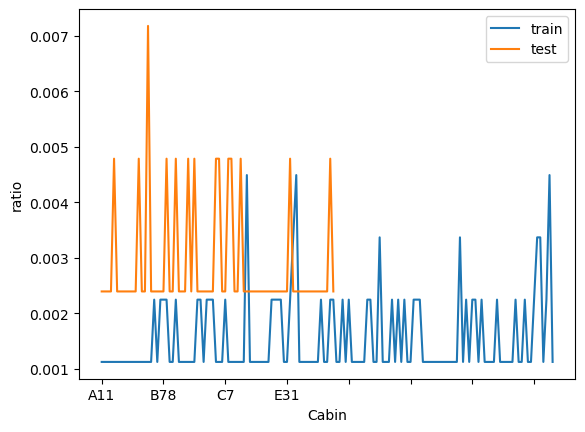

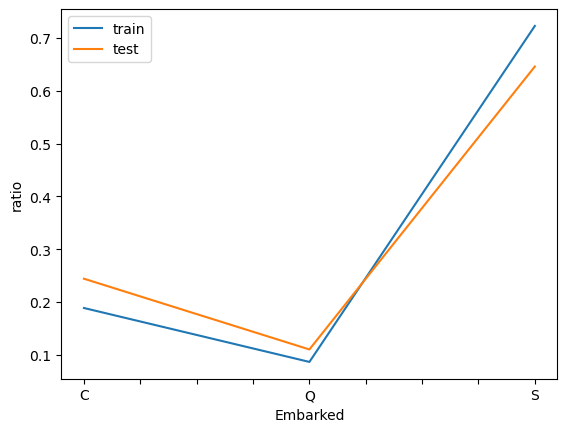

In [15]:
### 通过比率定量查看
train_count = train.shape[0]
test_count = test.shape[0]
for feature in features:
    (train[feature].value_counts().sort_index()/train_count).plot()  # 得到的是比率
    (test[feature].value_counts().sort_index()/test_count).plot()
    plt.legend(['train','test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\315066990.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\23599\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


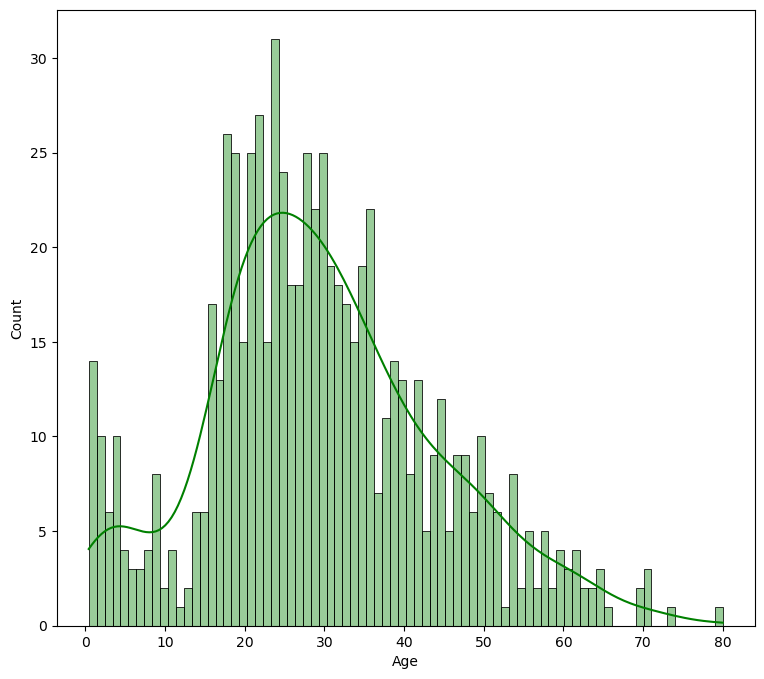

In [16]:
### 查看感兴趣的特征的分布
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 如果数据中有 inf，先处理
train['Age'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 绘制直方图
plt.figure(figsize=(9,8))
sns.histplot(train['Age'], color='g', bins=80, alpha=0.4, kde=True)
plt.show()
### 结论：我们可以看到，首先是低龄段，0-20之间是偏少的，奇怪的是10岁以下的偏多，可以猜测是贵族或者底层人员带着孩子。青年比较少，可能与这个时间阶段人际不支持，金钱不多，背景不够雄厚导致的。
### 随着年龄增大，人数逐渐攀升，20-30可以说是占据了人数的大多。正是充沛的劳动力占据主要人数，符合直觉，轮船上需要大量劳动力。
### 再随着年龄的增大，人数逐渐减少。这也符合直觉，理由是老龄人可能会是贵族，上层阶级，这部分人数不多；其次是老人经不起折腾，出门的事情还是少一点。

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\148199491.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Pclass'] , color = 'g'  , bins = 3 , hist_kws = {'alpha' : 0.4})
C:\Users\23599\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Pclass', ylabel='Density'>

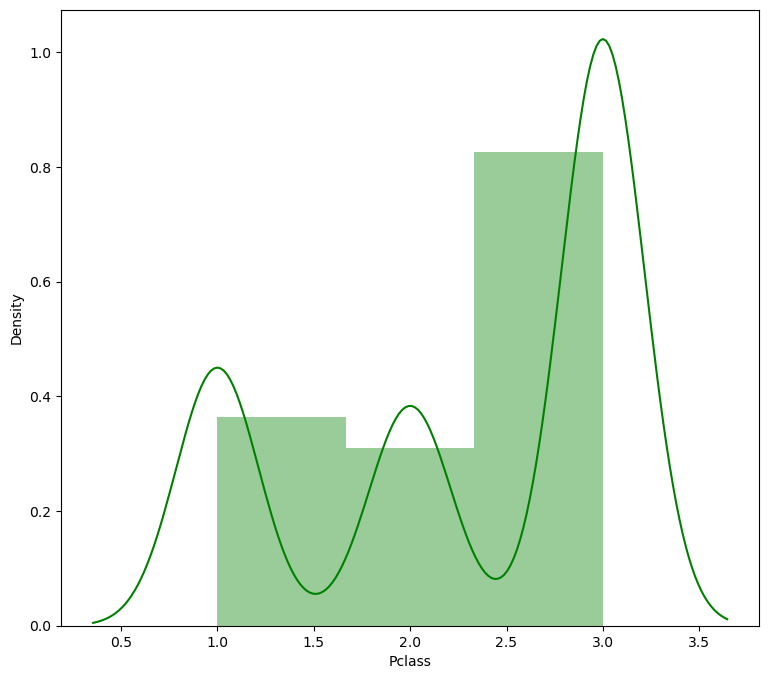

In [17]:
### 查看感兴趣的特征的分布
plt.figure(figsize=(9,8))
sns.distplot(train['Pclass'] , color = 'g'  , bins = 3 , hist_kws = {'alpha' : 0.4})  
### 结论：轮船底层社会的人民更多一些。本以为上流社会的会占主导。这样迎合了年龄的分析，年轻的很可能大多都是劳动力，因此属于底层人民。

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\2075154126.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Fare'] , color = 'g'  , bins = 50 , hist_kws = {'alpha' : 0.4})
C:\Users\23599\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Fare', ylabel='Density'>

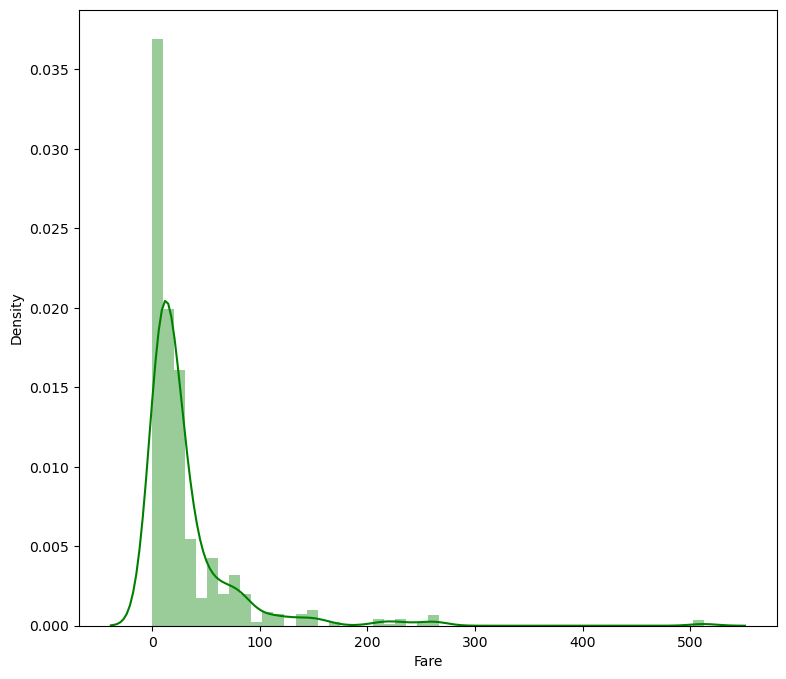

In [18]:
### 查看感兴趣的特征的分布
plt.figure(figsize=(9,8))
sns.distplot(train['Fare'] , color = 'g'  , bins = 50 , hist_kws = {'alpha' : 0.4})  
### 结论：票价支付的价格差异从0-500不等，集中分布在0-100之间。符合直觉。上面分析过了，底层人民更多，显然支付的票价更少。图像呈现偏离正态分布。取值范围比较狭窄，不使用log进行演示了，理由是会报错。

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\2475833948.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Parch'] , color = 'g'  , bins = 6 , hist_kws = {'alpha' : 0.4})
C:\Users\23599\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Parch', ylabel='Density'>

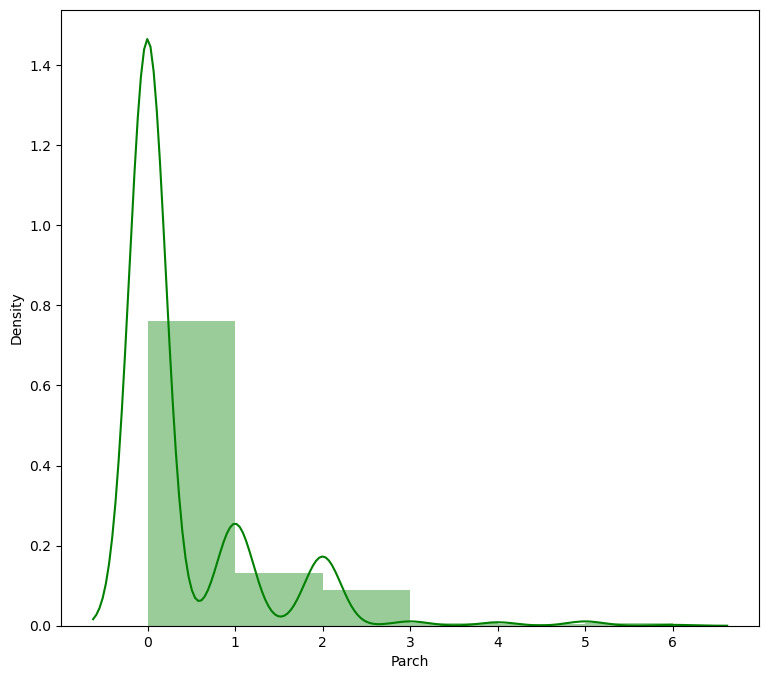

In [19]:
### 查看感兴趣的特征的分布
plt.figure(figsize=(9,8))
sns.distplot(train['Parch'] , color = 'g'  , bins = 6 , hist_kws = {'alpha' : 0.4})  
### 结论：大多数人不携带父母和子女，颇有一部分会携带一两人。极少数人会带上父母子女更多。符合直觉，劳动力不会携带子女来到劳动场所。

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\2146618054.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SibSp'] , color = 'g'  , bins = 8 , hist_kws = {'alpha' : 0.4})
C:\Users\23599\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SibSp', ylabel='Density'>

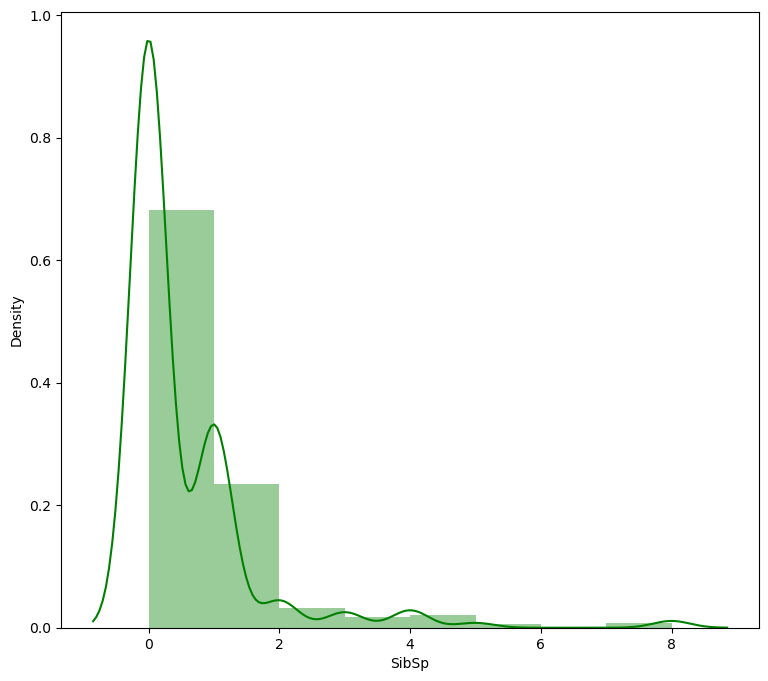

In [20]:
### 查看感兴趣的特征的分布
plt.figure(figsize=(9,8))
sns.distplot(train['SibSp'] , color = 'g'  , bins = 8 , hist_kws = {'alpha' : 0.4})  
### 结论：大多数不携带兄弟姐妹和配偶，只有极少数会携带大家庭。符合直觉，劳动力一般不会携带兄弟来到劳动场所，除非兄弟一起来打工。

### 多变量联合特征
这部分是我认为EDA最复杂，最难分析的一部分。幸运的是，特征数目少，值得考虑的东西并不多。
注意，由于本实验的特征比较少，所以适合绘制的和不适合绘制的联合特征一并绘制了出来。

['PassengerId', 'Pclass']


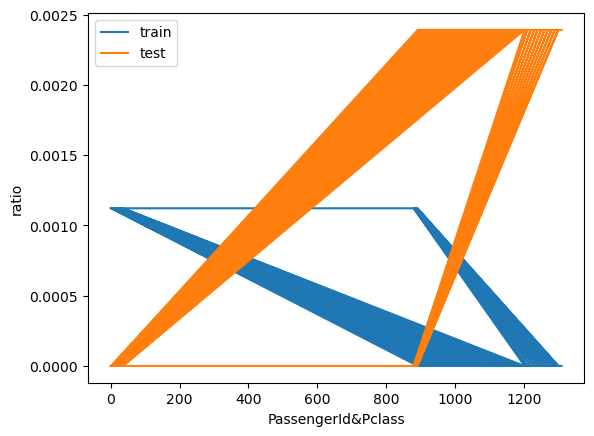

['PassengerId', 'Name']


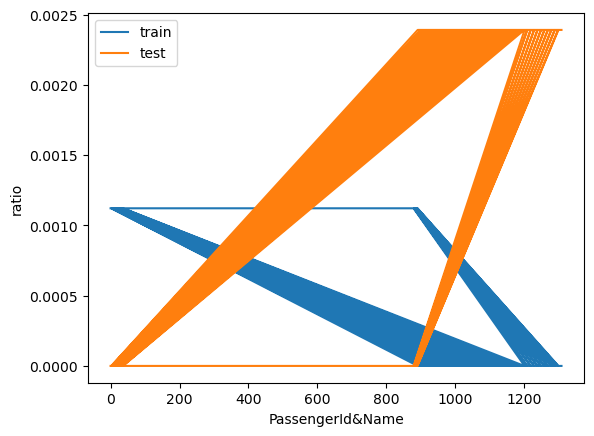

['PassengerId', 'Sex']


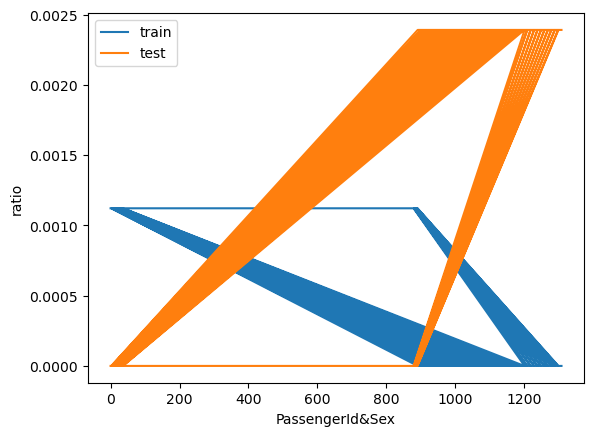

['PassengerId', 'Age']


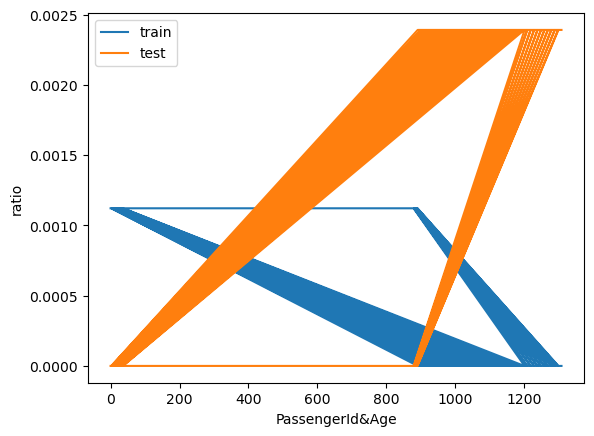

['PassengerId', 'SibSp']


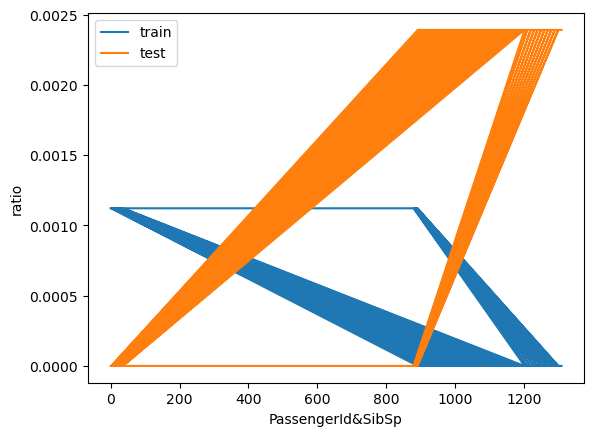

['PassengerId', 'Parch']


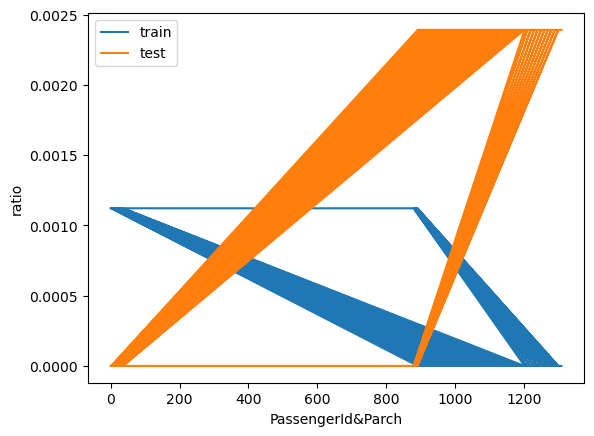

['PassengerId', 'Ticket']


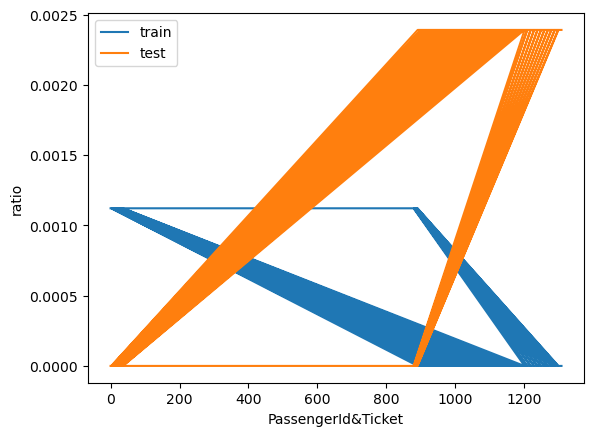

['PassengerId', 'Fare']


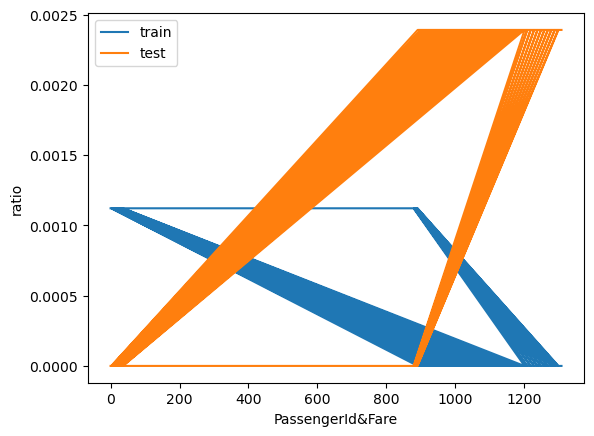

['PassengerId', 'Cabin']


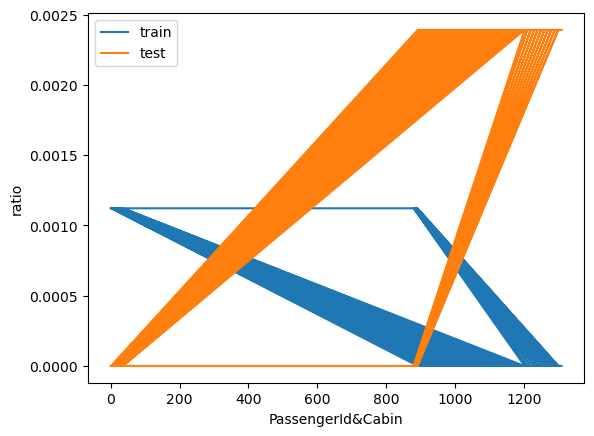

['PassengerId', 'Embarked']


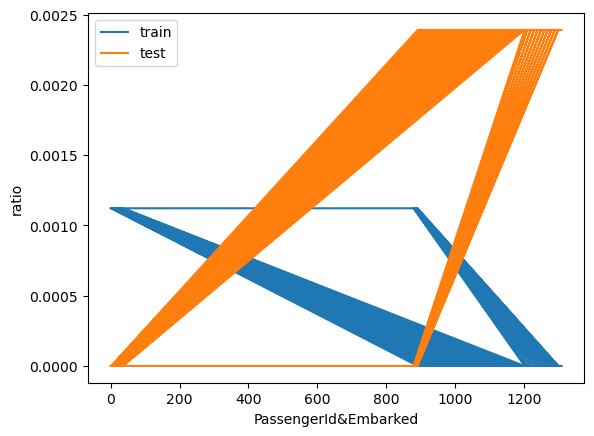

['Pclass', 'Name']


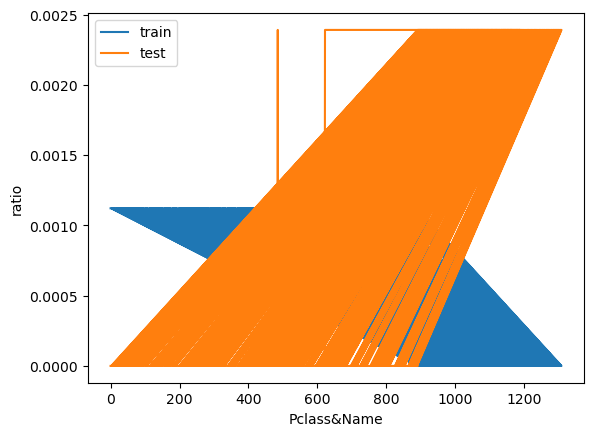

['Pclass', 'Sex']


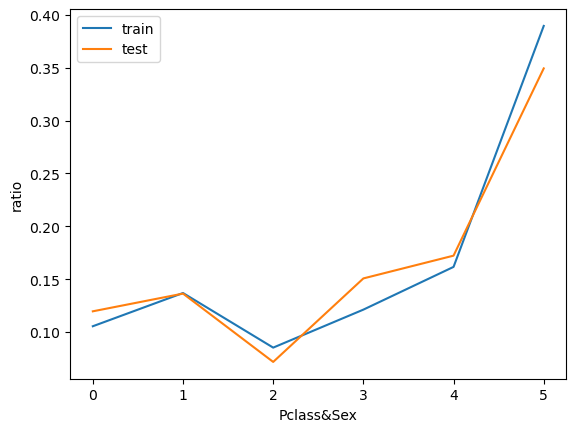

['Pclass', 'Age']


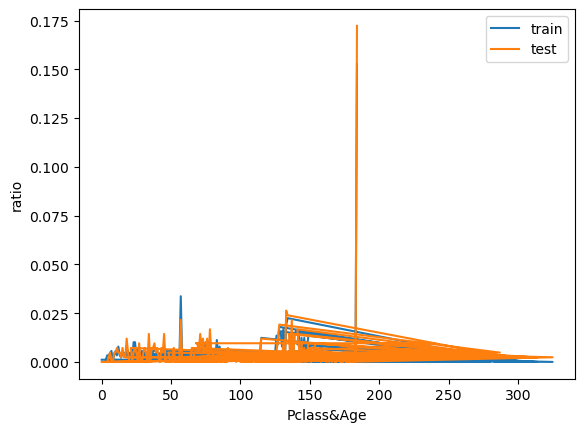

['Pclass', 'SibSp']


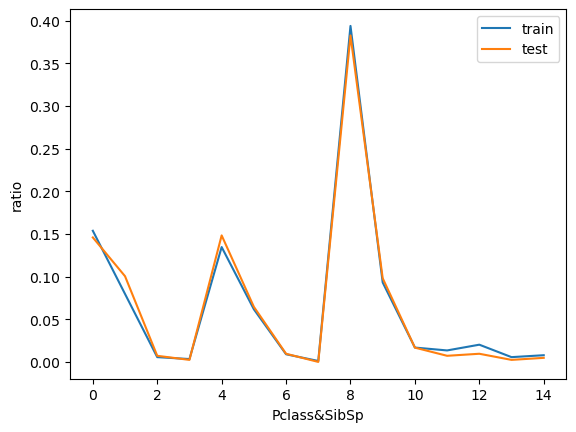

['Pclass', 'Parch']


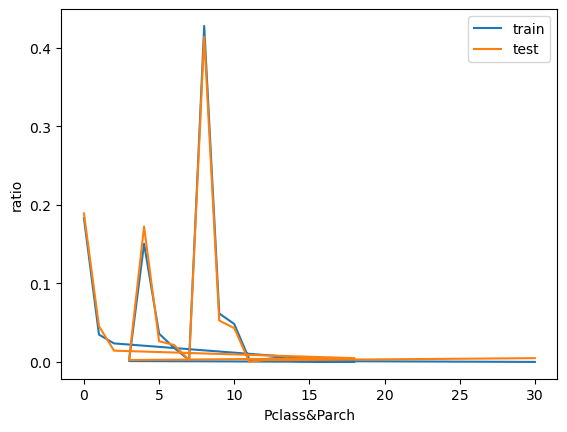

['Pclass', 'Ticket']


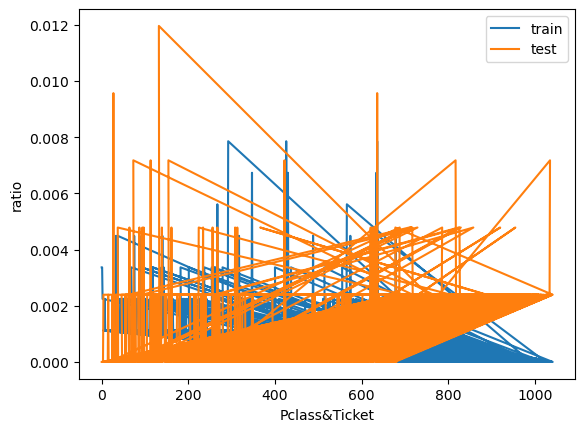

['Pclass', 'Fare']


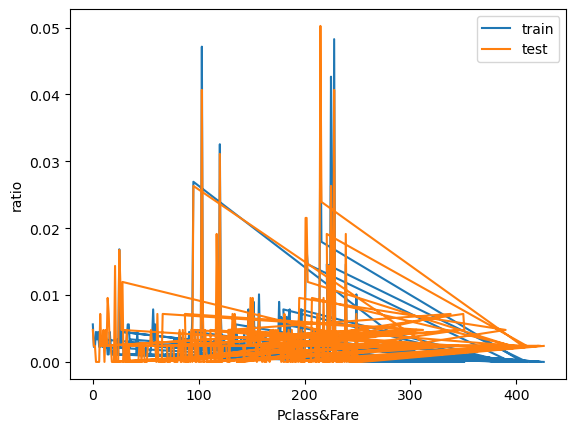

['Pclass', 'Cabin']


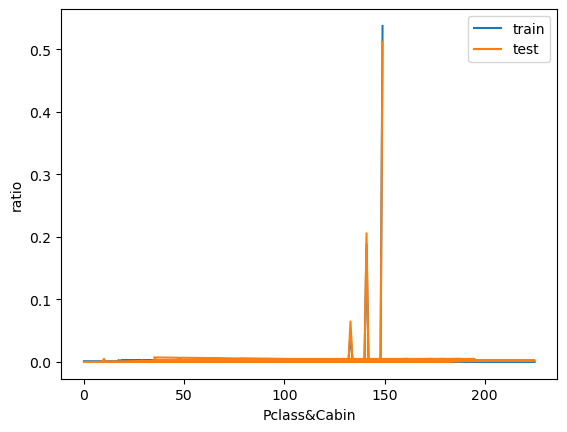

['Pclass', 'Embarked']


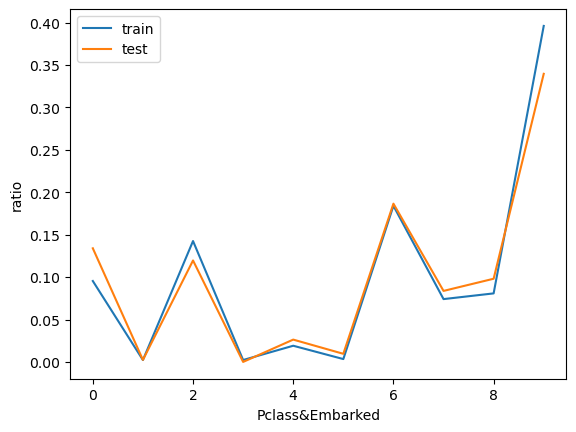

['Name', 'Sex']


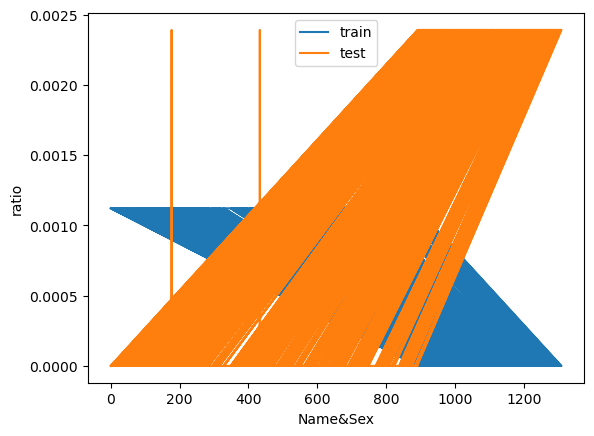

['Name', 'Age']


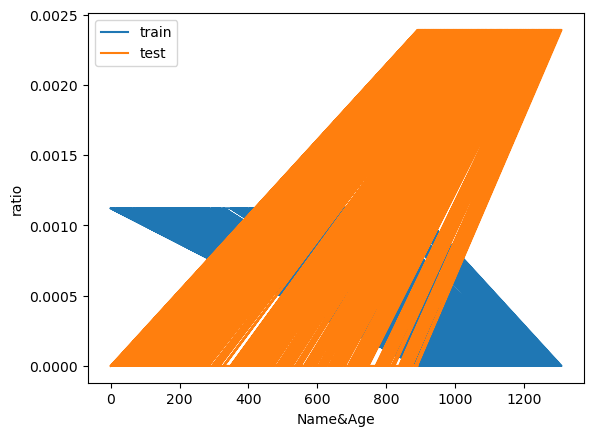

['Name', 'SibSp']


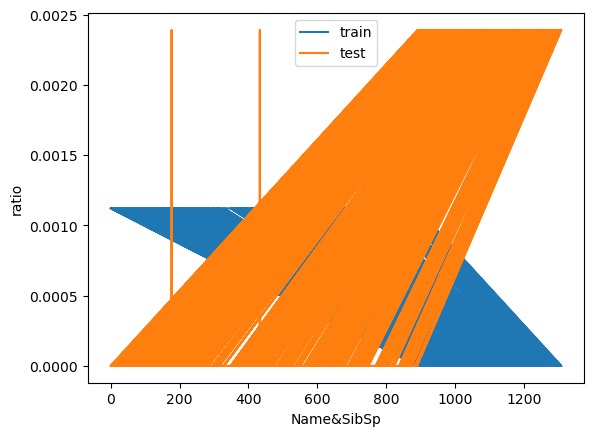

['Name', 'Parch']


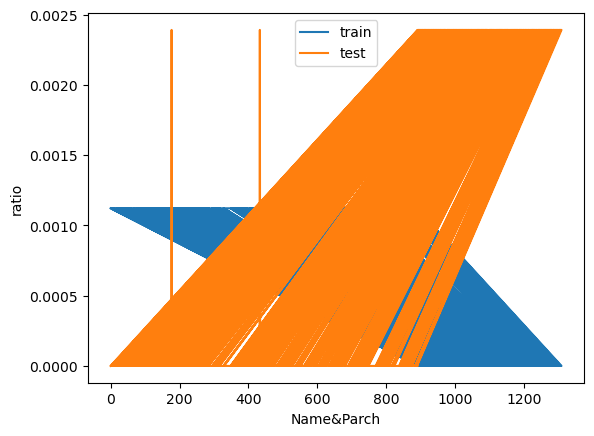

['Name', 'Ticket']


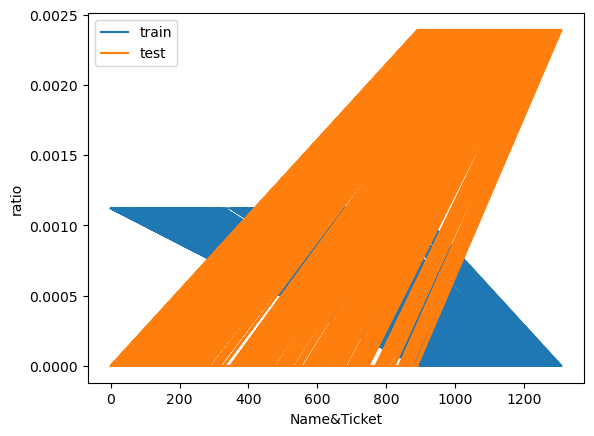

['Name', 'Fare']


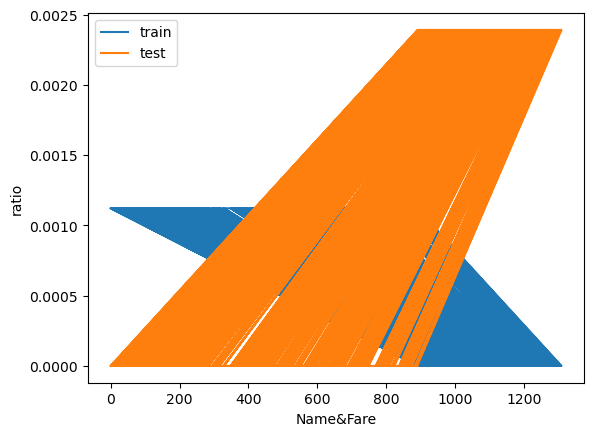

['Name', 'Cabin']


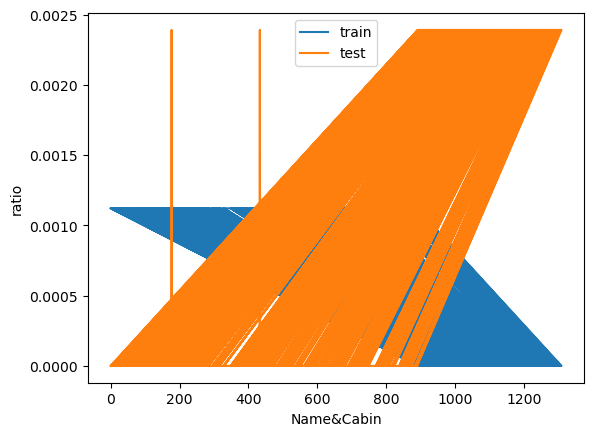

['Name', 'Embarked']


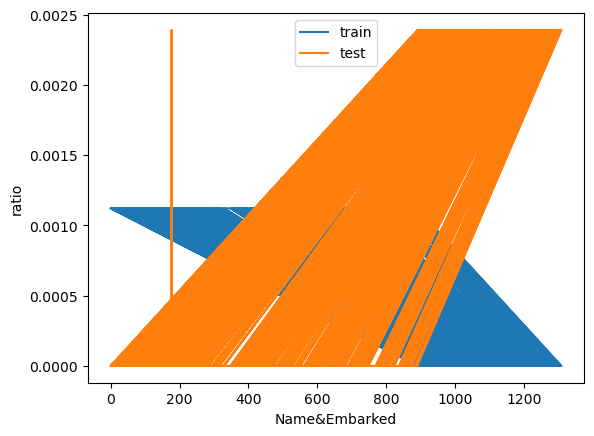

['Sex', 'Age']


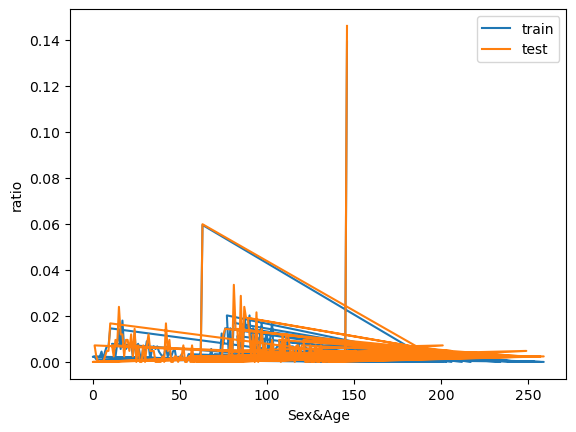

['Sex', 'SibSp']


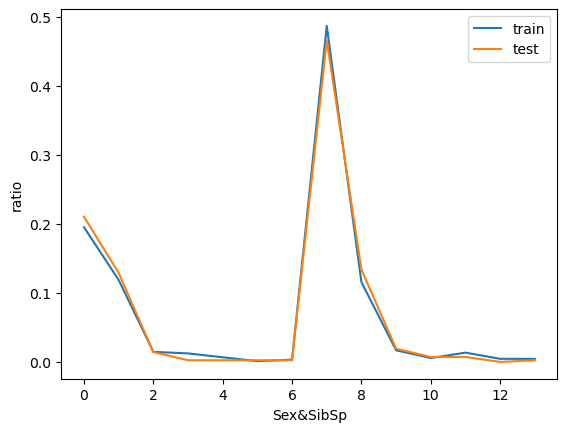

['Sex', 'Parch']


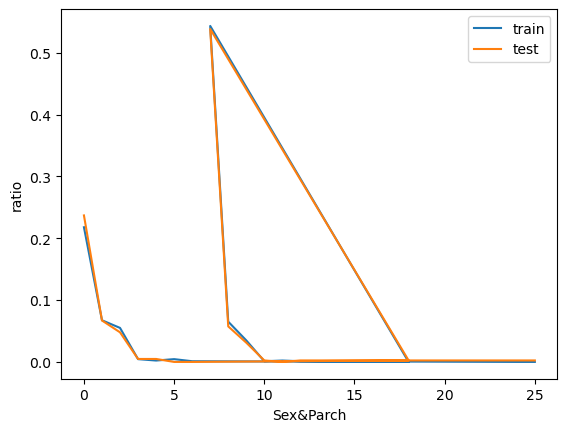

['Sex', 'Ticket']


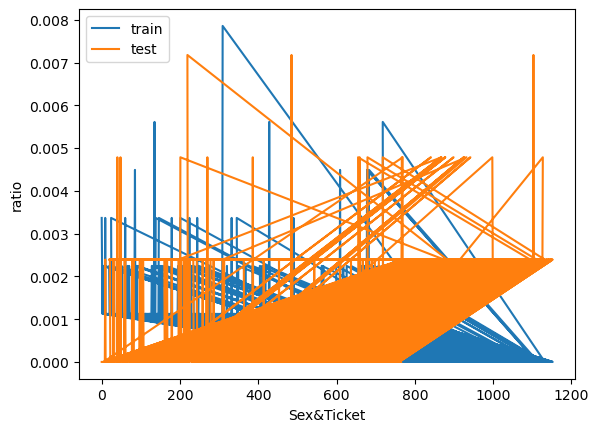

['Sex', 'Fare']


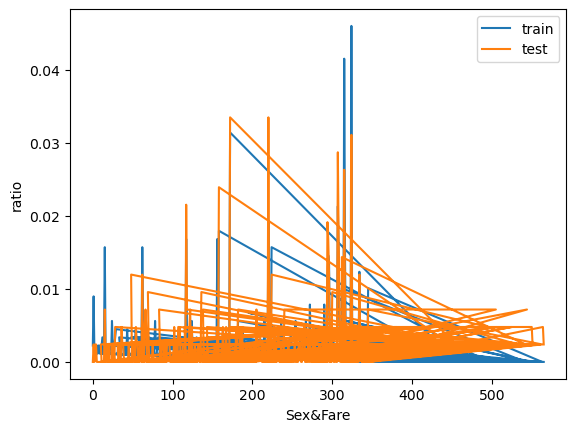

['Sex', 'Cabin']


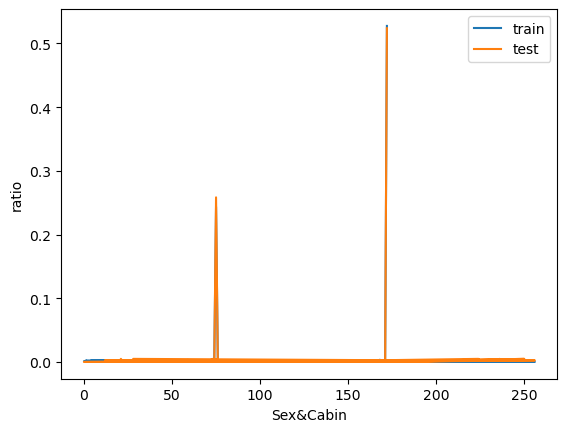

['Sex', 'Embarked']


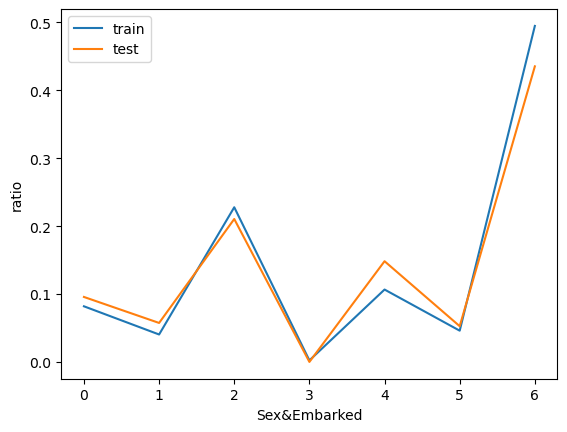

['Age', 'SibSp']


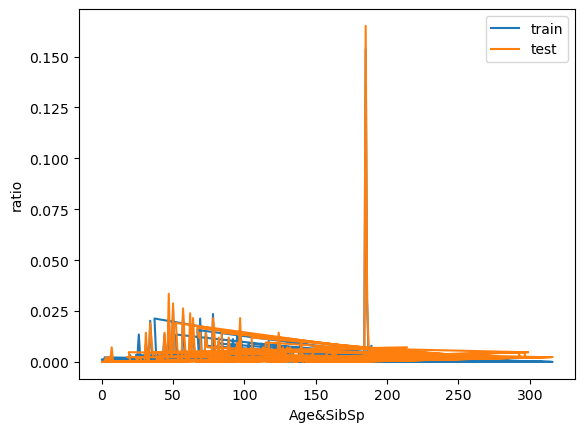

['Age', 'Parch']


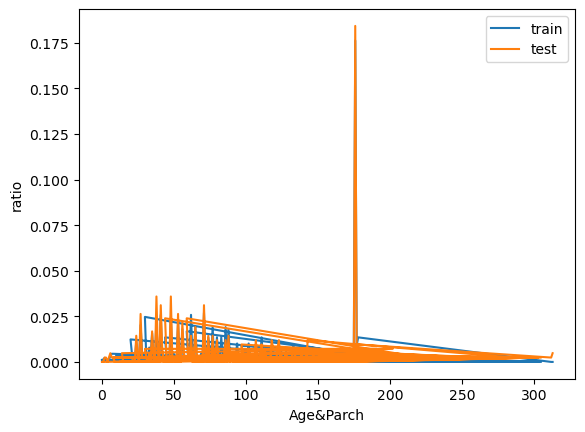

['Age', 'Ticket']


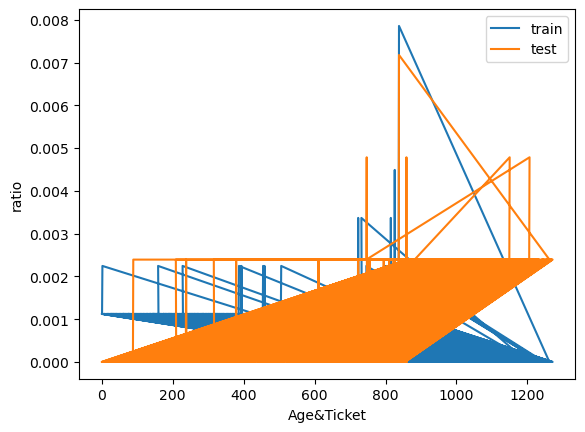

['Age', 'Fare']


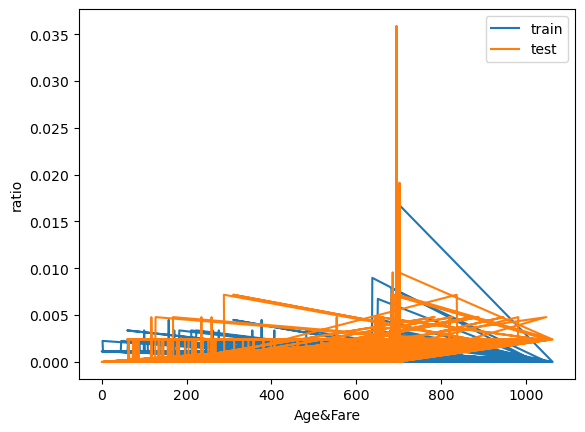

['Age', 'Cabin']


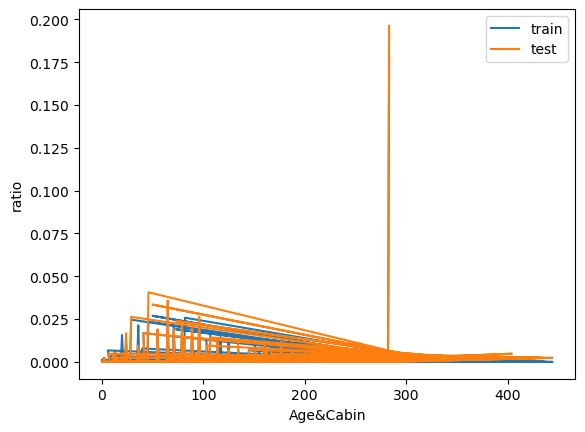

['Age', 'Embarked']


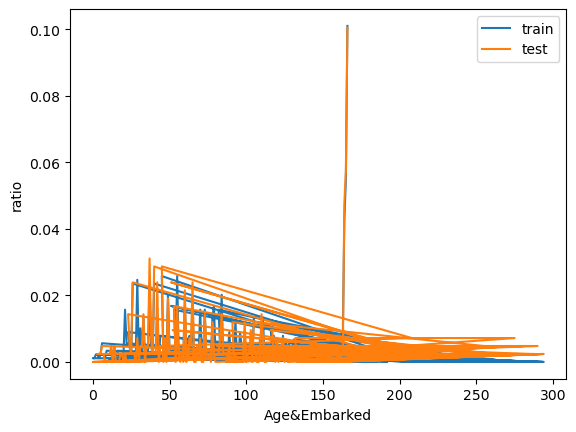

['SibSp', 'Parch']


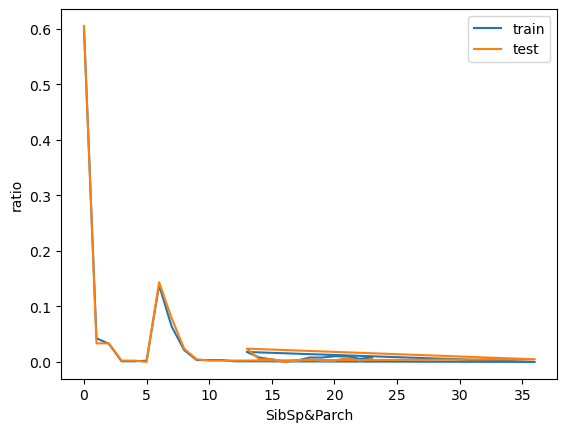

['SibSp', 'Ticket']


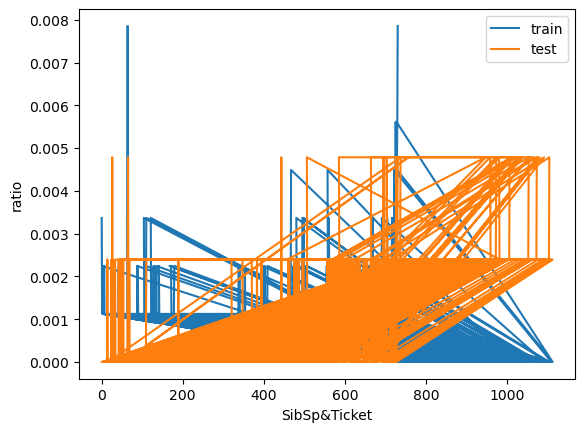

['SibSp', 'Fare']


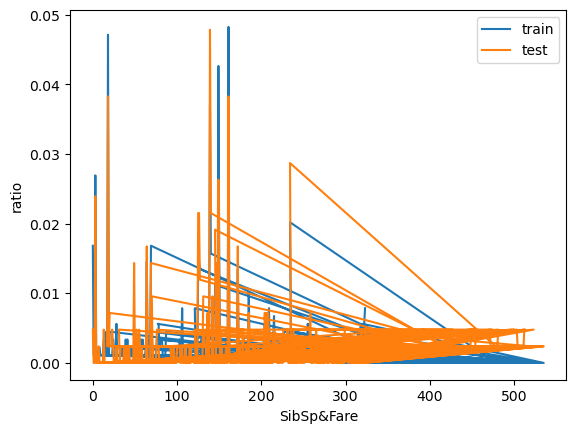

['SibSp', 'Cabin']


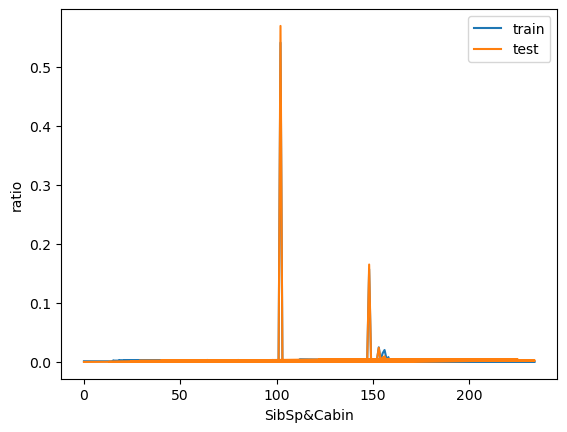

['SibSp', 'Embarked']


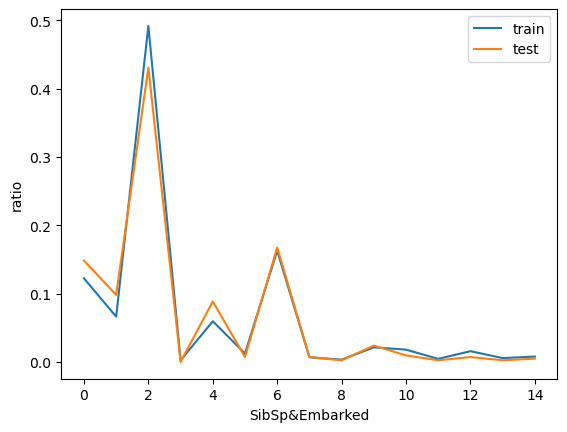

['Parch', 'Ticket']


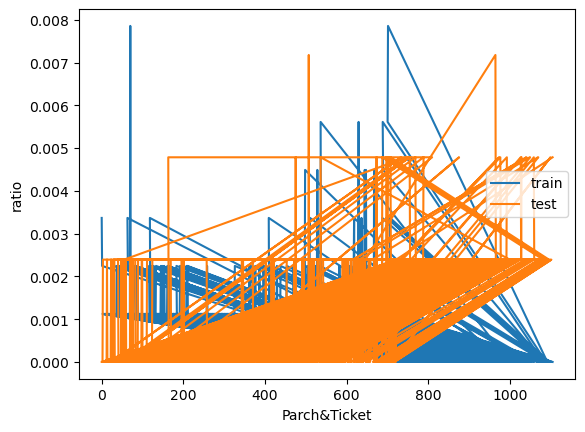

['Parch', 'Fare']


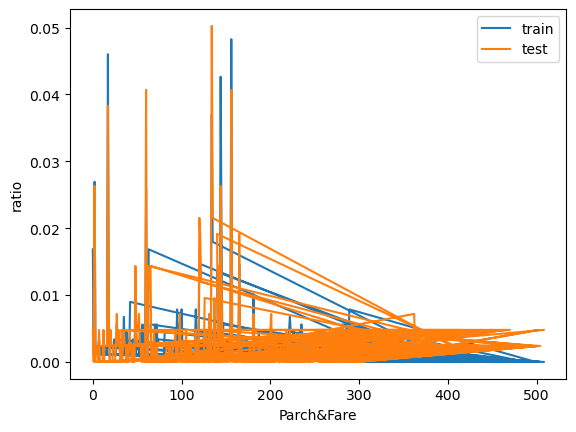

['Parch', 'Cabin']


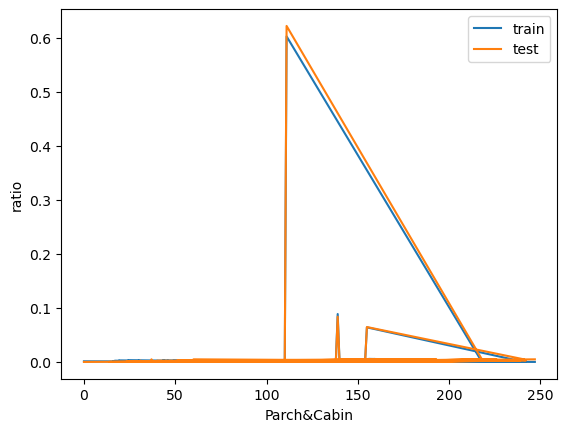

['Parch', 'Embarked']


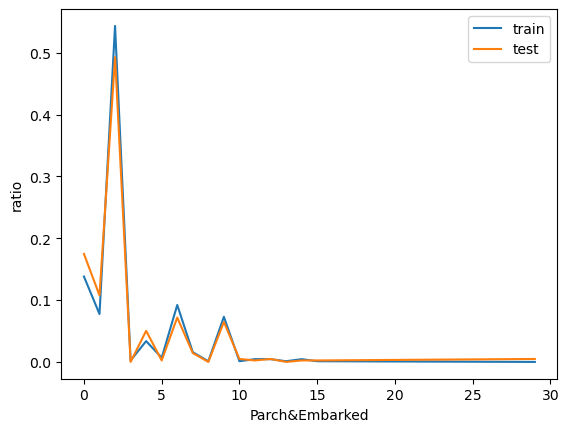

['Ticket', 'Fare']


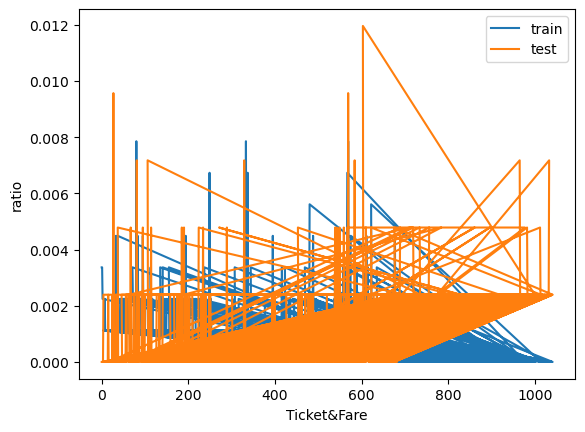

['Ticket', 'Cabin']


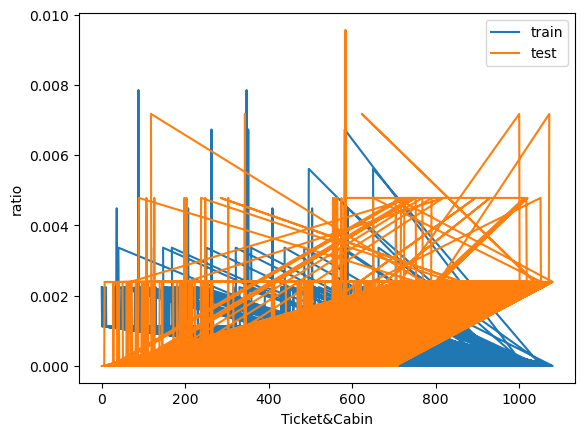

['Ticket', 'Embarked']


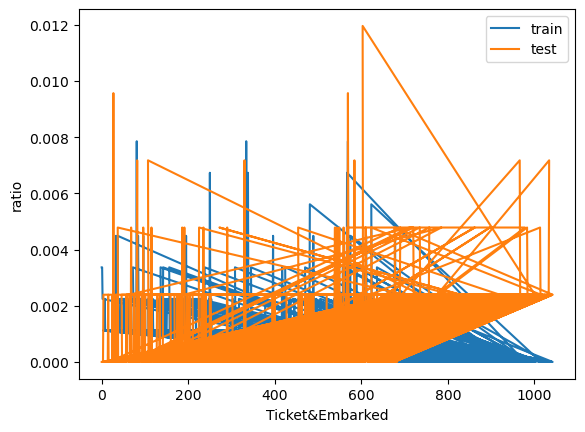

['Fare', 'Cabin']


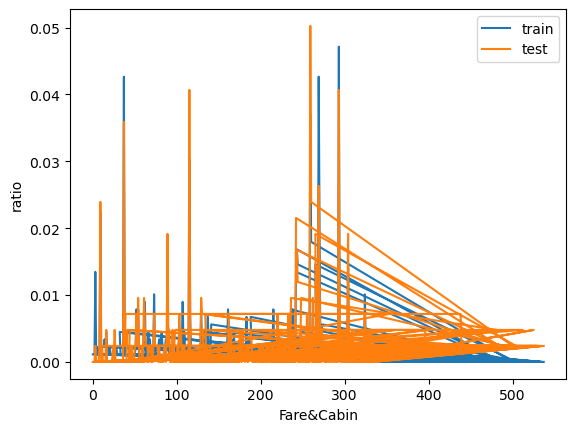

['Fare', 'Embarked']


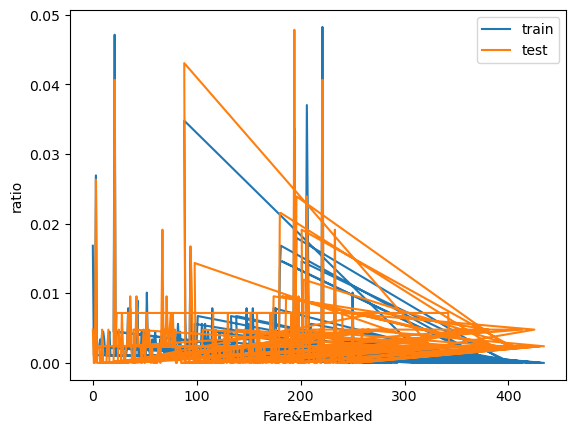

['Cabin', 'Embarked']


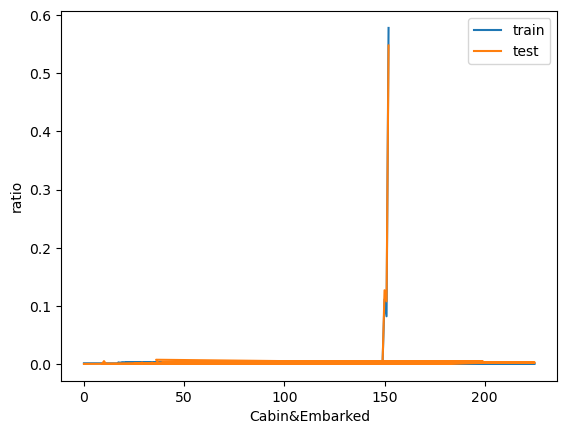

In [21]:
def combine_feature(df):
    cols = df.columns
    feature1 = df[cols[0]].astype(str).values.tolist()
    feature2 = df[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i]+'&'+feature2[i] for i in range(df.shape[0])])

n = len(features)  # 探究f的长度
for i in range(n-1):
    for j in range(i+1, n):
        cols = [features[i], features[j]]  # 拼接
        print(cols)
        train_dis = combine_feature(train[cols]).value_counts().sort_index()/train_count
        test_dis = combine_feature(test[cols]).value_counts().sort_index()/test_count
        index_dis = pd.Series(train_dis.index.tolist() + test_dis.index.tolist()).drop_duplicates().sort_values()
        (index_dis.map(train_dis).fillna(0)).plot()
        (index_dis.map(test_dis).fillna(0)).plot()
        plt.legend(['train','test'])
        plt.xlabel('&'.join(cols))
        plt.ylabel('ratio')
        plt.show()
### 值得关注的特征的交叉特征，train和test的分布惊人一致，因此无需担心偏差问题。


### 最后附上相似性矩阵作为EDA的结尾

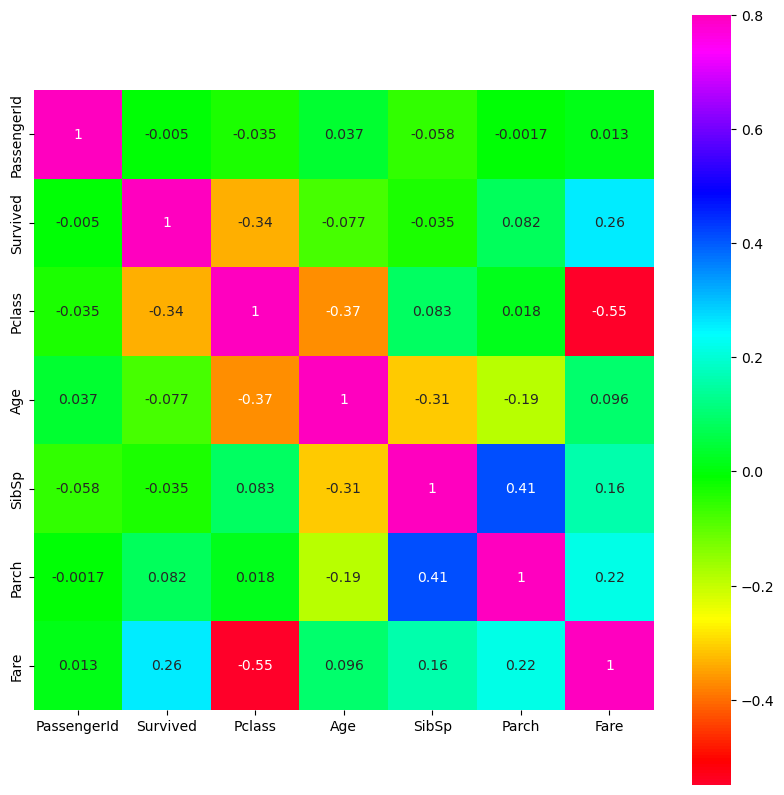

In [22]:
# 只选择数值型列
numeric_features = train.select_dtypes(include=['int64', 'float64'])

# 计算相关系数
corrmat = numeric_features.corr()

# 绘制热力图
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmax=0.8, square=True, cmap="gist_rainbow", annot=True)
plt.show()

##  结论：
### 热力图给出的信息是十分巨大的。其中绿色偏多，是个好事

### 首先是查看变量和标签之间的关系。
### ----------------------------------------------------------------------------------------------
### 可以发现阶层信息与存活呈现负相关，符合直觉。没钱就不被关心死活。Pclass是重要特征，必须给予保留。
### 票价和存活呈现正相关，符合直觉，买的票越贵多半是贵族，存活的概率就大一点。
### 年龄和存活的关系并不明显，符合直觉。存活的多半是年龄适中的，不会和存活概率呈现简单的线性正相关。
### 携带亲属个数和存活关系不明显，符合直觉，因为比较难以联想到他们之间的关系。
### ----------------------------------------------------------------------------------------------


### 其次查看变量之间的关系，方便后续做特征交叉。
### ---------------------------------------------------------------------------------------------------
### 首先，是年龄和阶级呈现一种负相关。这符合我们之间的推断。年龄大的社会阶级数目低（阶级数低代表等级高），换言之，年龄越大阶级越高，年龄越低说明他很可能是劳动力。
### 票价和阶级呈现负相关，符合直觉。因为票价越高，说明社会阶级越高，说明阶级数字越小，因此是负相关。
### 年龄和携带的配偶、兄弟姐妹的数目是呈现负相关的，符合直觉，为什么不做过多解释。
### 年龄和携带的父母、子女的数目是略微呈现负相关（偏黄绿）的，也比较符合直觉。
### 携带配偶、兄弟姐妹的数目和携带父母、子女的数目是呈现明显正相关的。我们可以猜测，游客一带，就是带了一家子过来。比较符合直觉。
### 携带陪同的信息与票价的信息呈现的关系并不明显。
### ---------------------------------------------------------------------------------------------------

<Axes: ylabel='count'>

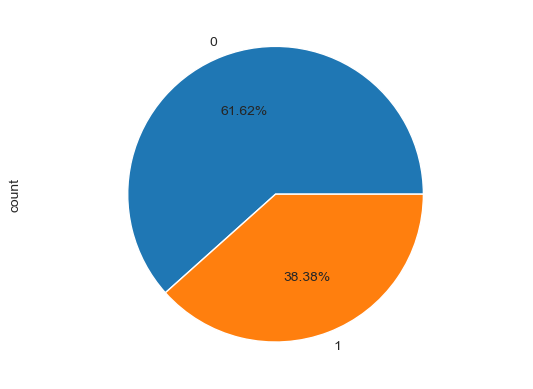

In [23]:
# 分析已知存活数据中的存活比例
train_survived=train[train['Survived'].notnull()]
sns.set_style('ticks') # 十字叉
plt.axis('equal')       #行宽相同
train_survived['Survived'].value_counts().plot.pie(autopct='%1.2f%%')



In [24]:
# 分析男性和女性存活情况
# 按性别和存活情况统计数量
survive_sex = train.groupby(['Sex','Survived'])['Survived'].count()

# 计算女性存活率
female_survival_rate = survive_sex.loc['female',1] / survive_sex.loc['female'].sum() * 100
male_survival_rate   = survive_sex.loc['male',1] / survive_sex.loc['male'].sum() * 100

print('女性存活率 %.2f%%, 男性存活率 %.2f%%' % (female_survival_rate, male_survival_rate))



女性存活率 74.20%, 男性存活率 18.89%


Sex       female  male
Survived              
0             81   468
1            233   109


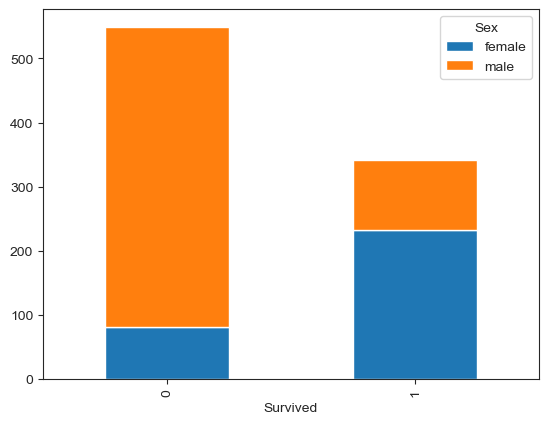

In [25]:
# 查看survived 与 Sex的关系
Survived_Sex = train['Sex'].groupby(train['Survived'])
print(Survived_Sex.value_counts().unstack())

Survived_Sex.value_counts().unstack().plot(kind = 'bar', stacked = True)
plt.show()


In [ ]:
# 从数据分析的结果来看，女性存活率74.20%远高于男性存活率18.89%
# 一方面，女性体内的含脂量是高于男性的，在水中不易溺水
# 另一方面，事故发生时，青壮年男性一般会将救生艇和救生衣优先提供给女性，从这一角度而言，可以较好地解释女性存活率远高于男性

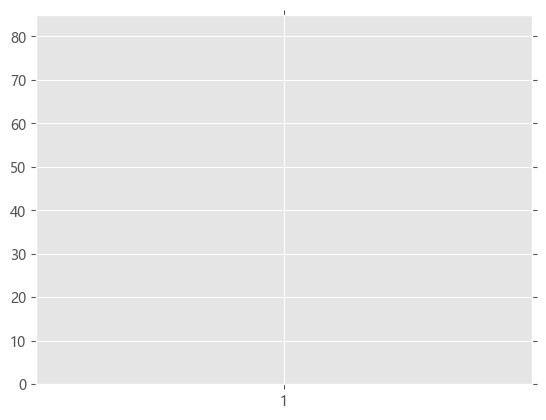

In [26]:
# 设置图形的显示风格
plt.style.use('ggplot')
# 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

plt.boxplot(x = train.Age, # 指定绘图数据
            patch_artist=True, # 要求用自定义颜色填充盒形图，默认白色填充
            showmeans=True, # 以点的形式显示均值
            boxprops = {'color':'black','facecolor':'#9999ff'}, # 设置箱体属性，填充色和边框色
            flierprops = {'marker':'o','markerfacecolor':'red','color':'black'}, # 设置异常值属性，点的形状、填充色和边框色
            meanprops = {'marker':'D','markerfacecolor':'indianred'}, # 设置均值点的属性，点的形状、填充色
            medianprops = {'linestyle':'--','color':'orange'}) # 设置中位数线的属性，线的类型和颜色
 
plt.ylim(0,85)
plt.tick_params(top='off', right='off')
plt.show()

In [30]:
# 根据箱形图，可以看到，主要的年龄段集中在20-35岁左右
# 但同时，也有部分年纪较小和年纪很大的乘客

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\1344808245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_age['Age'] = train_age['Age'].astype(int)


<Axes: xlabel='Age', ylabel='Survived'>

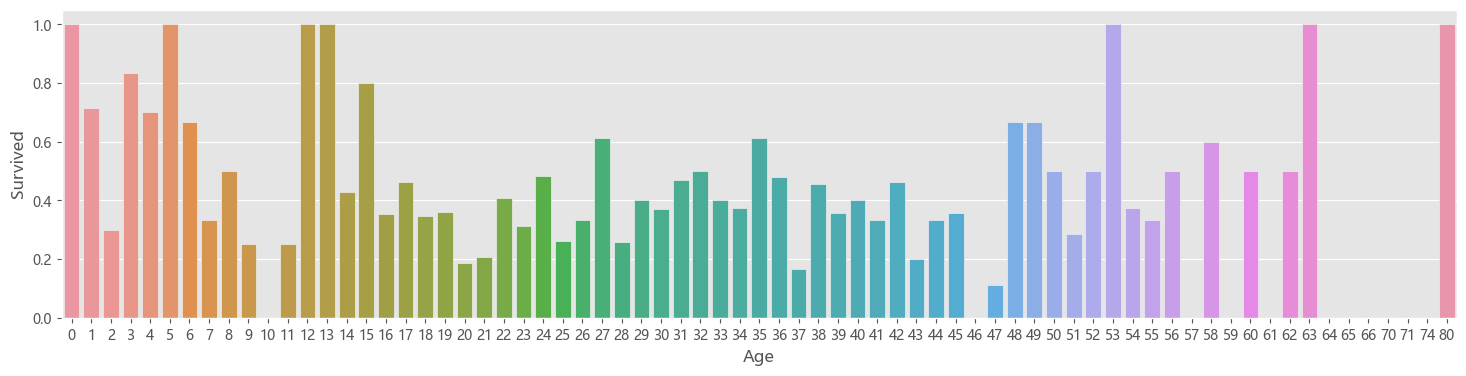

In [27]:
plt.figure(figsize=(18,4))
train_age=train[train['Age'].notnull()]
train_age['Age'] = train_age['Age'].astype(int)
average_age=train_age[['Age','Survived']].groupby('Age',as_index=False).mean()

sns.barplot(x='Age',y='Survived',data=average_age)


In [ ]:
# 我们可以看到，age段为儿童以及老人的获救率高于青壮年
# 原因解释可以类比女性，即在出事故时，对于老人和儿童进行优先救助

<Axes: title={'center': 'Fare'}, xlabel='Pclass'>

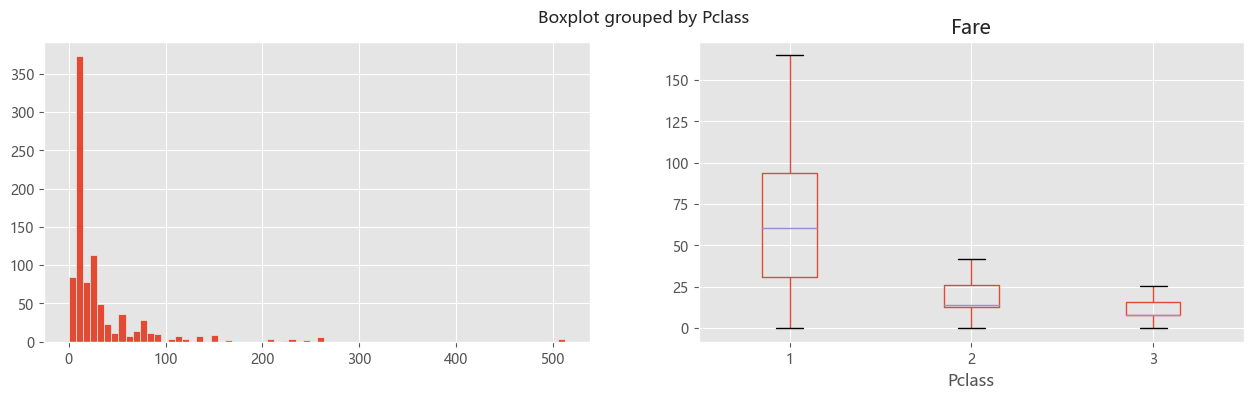

In [28]:
# Survived与Fare的关系
fig,ax=plt.subplots(1,2,figsize=(15,4))
train['Fare'].hist(bins=70,ax=ax[0])
train.boxplot(column='Fare',by='Pclass',showfliers=False,ax=ax[1])



In [ ]:
# 根据前面的热力图以及绘制的箱型图
# Fare主要集中在10左右
# Pclass与Fare存在负相关，即Pclass越高，Fare越低


Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


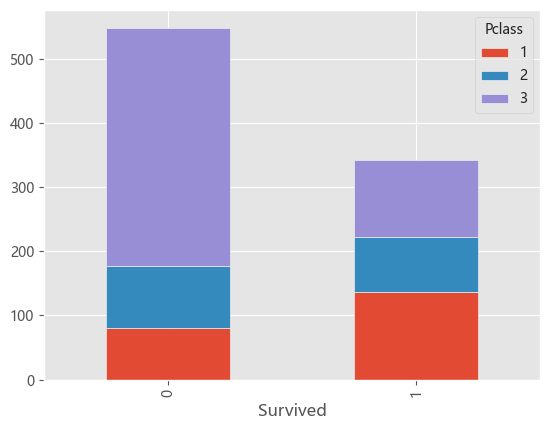

In [29]:
# 查看Survived 与 Pclass的关系
Survived_Pclass = train['Pclass'].groupby(train['Survived'])
print(Survived_Pclass.value_counts().unstack())

Survived_Pclass.value_counts().unstack().plot(kind = 'bar', stacked = True)
plt.show()

In [ ]:
# 在未获救的人员中，Pclass=3的人占据大多数，Pclass=1和2的人分布平均
# 而在已获救的人中，Pclass=1的人占据大多数，Pclass=2和3的人分布平均

## 1 EDA结论
1. 特征中"Cabin"字段严重缺失，导致train和test的分布严重不同，将给予删除操作。
2. 姓名字段无用，我们给予删除操作。
3. 两个文件的Age字段均略有缺失，我们给予填充平均值的操作。
4. test文件的Fare字段有一个缺失。我们不做处理。理由是梯度提升树对缺失值友好。
5. 其余特征，基本是一致的。 
6. 可以考虑对票价和阶级两个特征进行交叉。new_feature1 = fare * (4-阶级) 。 这样得到的是正数，而且预计和标签呈现正相关。有助于强化标签和变量之间的关系。
7. 年龄和生存之间不是简单的线性关系并不意味着他们之间没有关系。
因为年龄和阶级之间存在负关系，阶级和标签也存在负关系，因此可以我们的任务是挖掘出年龄和标签的关系。
所以我们可以考虑对 年龄和亲属做交叉，以此强化年龄特征。new_feature2 = age * (sib+par) 
8. 由于字段的range比较狭窄，初步鉴定没有寻找异常值的必要。
9. 数据分布范围不大，没有归一化的愿望驱动。

# 2.FE 特征工程
特征工程决定了我们最终结果的上限。FE是我们本次实验工作的重点之一。任务主要包括EDA给予的结论。
1. 移除Cabin
2. 移除name
3. 填充Age
4. 做特征交叉
5. 保存4个预处理的文件。（1. 无特征交叉  2. 含有交叉1  3.含有交叉2  4.含有两个交叉）
-------------------------------------------------------------------------------------
其中，特征交叉包括

4.1 new_feature1 = fare * (4-阶级)

4.2 new_feature2 = age * (sib+par) 


In [30]:
### 1. 移除Cabin ， 注意保持train和test的一致
train.drop(columns=['Cabin'] , axis=0,inplace=True)

In [31]:
test.drop(columns=['Cabin'] , axis=0,inplace=True)

In [32]:
### 2. 移除name , 注意保持train和test的一致性
train.drop(columns=['Name'] , axis= 0 , inplace=True)
test.drop(columns=['Name'] , axis= 0 , inplace=True)

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\977292177.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["Age"].dropna(),hist=True,kde=True)
C:\Users\23599\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Density'>

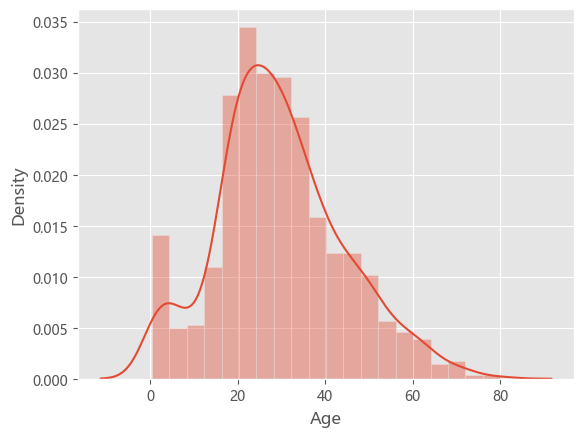

In [33]:
# 3. 填充Age
sns.distplot(train["Age"].dropna(),hist=True,kde=True)

In [34]:
train["Age"].replace(np.nan,np.nanmedian(train["Age"]),inplace=True)
test["Age"].replace(np.nan,np.nanmedian(train["Age"]),inplace=True)  ### 注意，这里严格使用train['Age']进行test的Age字段填充，一个基本而又重要的考点

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\3374168866.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Age"].replace(np.nan,np.nanmedian(train["Age"]),inplace=True)
C:\Users\23599\AppData\Local\Temp\ipykernel_31192\3374168866.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [35]:
### 4.0 保存无特征交叉的文件
train.to_csv("./processed/train_without_cross.csv" , index=0)
test.to_csv("./processed/test_without_cross.csv" , index= 0)

In [36]:
### 4.1 做cross1 公式：cross1 = fare * (4-阶级)
train['cross1'] = train['Fare'] * (4-train['Pclass']) 
test['cross1'] = test['Fare'] * (4-test['Pclass'])   ### 保持test同步

In [37]:
### 4.1 保留cross1交叉文件
train.to_csv("./processed/train_with_cross1.csv" , index=0)
test.to_csv("./processed/test_with_cross1.csv" , index=0)

In [38]:
### 4.2 做cross1 公式：cross2 = age * (sib+par)
train['cross2'] = train['Age'] * (train['SibSp'] + train['Parch']) 
test['cross2'] = test['Age'] * (test['SibSp'] + test['Parch']) 

In [39]:
train.to_csv("./processed/train_with_cross12.csv" , index=0)
test.to_csv("./processed/test_with_cross12.csv" , index= 0)

In [40]:
tmp = train.columns.to_list()


In [41]:
tmp.remove('cross1')

In [42]:
train[tmp].to_csv("./processed/train_with_cross2.csv" , index = 0 )

In [43]:
tmp.remove('Survived')
test[tmp].to_csv("./processed/test_with_cross2.csv" , index= 0)

## 基础文件处理到这里
接下来的处理直接基于cross12


In [44]:
train = pd.read_csv("processed/train_with_cross12.csv")
test  = pd.read_csv("processed/test_with_cross12.csv")

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\887685915.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Embarked"].replace(np.nan,'S',inplace=True)
C:\Users\23599\AppData\Local\Temp\ipykernel_31192\887685915.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

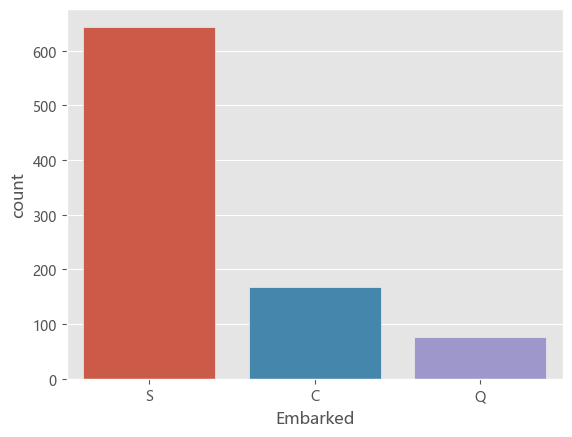

In [45]:
#### 进行Embark填充
sns.countplot(x="Embarked",data=train)
train["Embarked"].replace(np.nan,'S',inplace=True)
test["Embarked"].replace(np.nan,'S',inplace=True)

In [46]:
# 缺失值处理方式三： 特定值。 test 的 Fare字段只有一个缺失值，可以先看一下是哪位乘客的票价
test[np.isnan(test["Fare"])]

PassengerId  Pclass   Sex   Age  SibSp  Parch Ticket  Fare Embarked  cross1  cross2
152         1044       3  male  60.5      0      0   3701   NaN        S     NaN     0.0

In [47]:
# 由于乘客是从S港口登船的，并且社会阶层是3. 所有我们可以计算这一类别乘客的中值来替代
pclass_3_fares = test.query('Pclass==3 & Embarked=="S"')["Fare"]
pclass_3_fares = pclass_3_fares.replace(np.nan,0)
median_fare = np.median(pclass_3_fares)
test["Fare"].replace(np.nan,median_fare,inplace=True)
test["cross1"].replace(np.nan, median_fare ,inplace=True)

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\148039310.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["Fare"].replace(np.nan,median_fare,inplace=True)
C:\Users\23599\AppData\Local\Temp\ipykernel_31192\148039310.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [48]:
# 对于Sex数据，我们也需要进行处理，虽然它没有缺失值，但是 male，female并不能用来训练
train["Sex"].replace(["male","female"],[1,0],inplace=True)
test["Sex"].replace(["male","female"],[1,0],inplace=True)

C:\Users\23599\AppData\Local\Temp\ipykernel_31192\425256547.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Sex"].replace(["male","female"],[1,0],inplace=True)
C:\Users\23599\AppData\Local\Temp\ipykernel_31192\425256547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train["Sex"].repl

In [49]:
### 最后删除PID
train.drop(columns=['PassengerId'] , axis=0,inplace=True)
test.drop(columns=['PassengerId'], axis=0,inplace=True)

In [50]:
### 最后删除PID
train.drop(columns=['Ticket'] , axis=0,inplace=True)
test.drop(columns=['Ticket'], axis=0,inplace=True)

In [51]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
cross1      0
cross2      0
dtype: int64

In [52]:
test.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
cross1      0
cross2      0
dtype: int64

# 数据的清洗
到现在，数据是完整的，但是仍然有一些特征并不是数字或者向量的形式表征的，我们对这些特征进行 独热编码 （one-hot）表示

one-hot：把类别的变量值转换成0和1，并且形成一个矩形表，自身类别用1表示，其余类别用0表示

In [53]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [54]:
len(train.columns.to_list())

12

In [55]:
len(test.columns.to_list())

11

In [56]:
train.head()

Survived  Pclass  Sex   Age  SibSp  Parch  Fare  cross1  cross2  Embarked_C  Embarked_Q  Embarked_S
0         0       3    1  22.0      1      0   7.2     7.2    22.0       False       False        True
1         1       1    0  38.0      1      0  71.3   213.8    38.0        True       False       False
2         1       3    0  26.0      0      0   7.9     7.9     0.0       False       False        True
3         1       1    0  35.0      1      0  53.1   159.3    35.0       False       False        True
4         0       3    1  35.0      0      0   8.0     8.0     0.0       False       False        True

## 至此，数据的预处理结束。开始进行模型训练

In [57]:
### 保存可以直接进行处理的文件
train.to_csv("./processed/train_for_model.csv" , index=0 )
test.to_csv("./processed/test_for_model.csv" , index= 0 )

# 数据的分割

我们需要把完整的数据集拆分为
1. 特征与标签 
2. 训练集和测试集

提示：特征与标签可以直接通过dataframe的接口来定位column。需要用到的代码，如果你认真看完了我上面的代码，相信不在话下
训练集和测试集的分割我们仍然还是可以使用 train_test_split()

In [58]:
train = pd.read_csv("./processed/train_for_model.csv")
test = pd.read_csv("./processed/test_for_model.csv")

In [59]:
# import re
# train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# test = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
### 配合分类器使用，这里使用的是回归器，所以注释此段代码

In [60]:
def split_data(data,y_feature,seed):
    return train_test_split(data,data[y_feature],test_size=0.20,random_state=seed)
    raise NotImplementedError

In [61]:
### 注意只对train划出验证集来，test按兵不动
x_train,x_eval,y_train,y_eval = split_data(train,'Survived',20220319)   # 注意，train 里面含有标签 ，因此划分完毕之后应该手动去除标签
x_train.drop(columns=['Survived'] , axis= 0 , inplace=True) 
x_eval.drop(columns=['Survived'] , axis= 0 , inplace=True) 

# 3. Train 模型训练

本次实验我们选用梯度提升树进行训练。


![metrci](https://ai-studio-static-online.cdn.bcebos.com/26b3d12b6bbe4531bca12506bc3cd26097d88b07c9574c83959c56b3f81bf6cc)


In [126]:
params = {'num_leaves': 63,
          'min_child_samples': 50,
          'objective': 'regression',
          'learning_rate': 0.01,
          'boosting_type': 'gbdt',
          'metric': 'rmse',
          'verbose': -1,
         } 

In [127]:
dtrn = lgb.Dataset(x_train, label = y_train)
dval = lgb.Dataset(x_eval, label = y_eval) 

In [128]:
pip install --upgrade lightgbm

Note: you may need to restart the kernel to use updated packages.


In [129]:
bst = lgb.train(
    params,
    dtrn,
    num_boost_round=50,
    valid_sets=[dtrn, dval]
)

#### tip
[Warning] No further splits with positive gain, best gain: -inf 
虽然是一个警告，但其实是我们喜闻乐见的事情。这代表这模型大获成功。可以忽略。

In [130]:
y_pred_lgb = bst.predict(test)

In [131]:
y_pred_lgb

array([0.27580098, 0.38323782, 0.27580098, 0.29872769, 0.38323782,
       0.35032722, 0.51124376, 0.43242089, 0.51124376, 0.27098879,
       0.27335728, 0.41547963, 0.62985816, 0.27459203, 0.62985816,
       0.62985816, 0.27580098, 0.27635839, 0.38323782, 0.51124376,
       0.36538665, 0.35032722, 0.62985816, 0.39230419, 0.62985816,
       0.27459203, 0.62985816, 0.27635839, 0.41547963, 0.30453674,
       0.27459203, 0.43242089, 0.38323782, 0.38323782, 0.39230419,
       0.35032722, 0.51124376, 0.51124376, 0.27963194, 0.44239717,
       0.27580098, 0.44239717, 0.27580098, 0.58721785, 0.62985816,
       0.27270533, 0.41547963, 0.27936115, 0.62985816, 0.38323782,
       0.39230419, 0.30453674, 0.58721785, 0.62985816, 0.30453674,
       0.35032722, 0.27580098, 0.27035452, 0.29853287, 0.62985816,
       0.35032722, 0.30571305, 0.35032722, 0.51124376, 0.39230419,
       0.58721785, 0.51124376, 0.37536292, 0.44239717, 0.62985816,
       0.51124376, 0.26425701, 0.51124376, 0.44239717, 0.62985

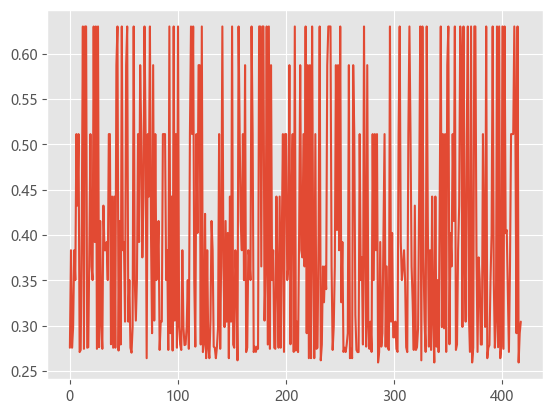

In [132]:
#  squares = [1,4,9,16,25]
fig, ax = plt.subplots()
ax.plot(y_pred_lgb)
plt.show()

In [133]:
np.mean(y_pred_lgb)

0.4012018938565633

In [134]:
pre_final = []
for x in y_pred_lgb :
    if x >= 0.41 :
        pre_final.append(1) 
    else : pre_final.append(0)

In [136]:
submit = pd.read_csv("./work/gender_submission.csv")
submit["Survived"] =  pre_final

In [137]:
submit

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

In [138]:
submit.to_csv("./submit/submit_lgb2.csv" , index=0)  # 将预测文件保存

In [79]:
### 保存模型
#bst.booster_.save_model('./model/lgb_binary_reg.txt')

# 4. Pseudo tag 伪标签
这是黑科技。

In [139]:
# train_set中抽取一部分作为新的validation_set
x_train,x_eval,y_train,y_eval = split_data(train,'Survived',20220325)  
x_train.drop(columns=['Survived'] , axis= 0 , inplace=True) 
x_eval.drop(columns=['Survived'] , axis= 0 , inplace=True) 


In [140]:
y_train

189    0
596    1
481    0
642    0
757    0
      ..
887    1
310    1
474    0
854    0
256    1
Name: Survived, Length: 712, dtype: int64

In [141]:
y_pred_lgb = pd.DataFrame(y_pred_lgb)
y_pred_lgb

0
0    275.8m
1    383.2m
2    275.8m
3    298.7m
4    383.2m
..      ...
413  291.8m
414  629.9m
415  259.5m
416  291.8m
417  304.5m

[418 rows x 1 columns]

In [142]:
# 将test_set的预测结果作为其pseudo-labeld
# 剩余部分与含有pseudo_labeled的test部分融合成新的train_set
x_train = pd.concat([x_train, test],axis=0)  
y_train = pd.concat([y_train, y_pred_lgb], axis=0) 


In [143]:
# 训练出model2
bst = lgb.train(
    params,
    dtrn,
    num_boost_round=50,
    valid_sets=[dtrn, dval]
)


In [144]:
#用model2对test_set进行预测
y_pred_lgb = bst.predict(test)


In [145]:
y_pred_lgb

array([0.27580098, 0.38323782, 0.27580098, 0.29872769, 0.38323782,
       0.35032722, 0.51124376, 0.43242089, 0.51124376, 0.27098879,
       0.27335728, 0.41547963, 0.62985816, 0.27459203, 0.62985816,
       0.62985816, 0.27580098, 0.27635839, 0.38323782, 0.51124376,
       0.36538665, 0.35032722, 0.62985816, 0.39230419, 0.62985816,
       0.27459203, 0.62985816, 0.27635839, 0.41547963, 0.30453674,
       0.27459203, 0.43242089, 0.38323782, 0.38323782, 0.39230419,
       0.35032722, 0.51124376, 0.51124376, 0.27963194, 0.44239717,
       0.27580098, 0.44239717, 0.27580098, 0.58721785, 0.62985816,
       0.27270533, 0.41547963, 0.27936115, 0.62985816, 0.38323782,
       0.39230419, 0.30453674, 0.58721785, 0.62985816, 0.30453674,
       0.35032722, 0.27580098, 0.27035452, 0.29853287, 0.62985816,
       0.35032722, 0.30571305, 0.35032722, 0.51124376, 0.39230419,
       0.58721785, 0.51124376, 0.37536292, 0.44239717, 0.62985816,
       0.51124376, 0.26425701, 0.51124376, 0.44239717, 0.62985

In [146]:
np.mean(y_pred_lgb)

0.4012018938565633

In [147]:
pre_final = []
for x in y_pred_lgb :
    if x >= 0.41 :
        pre_final.append(1) 
    else : pre_final.append(0)

In [148]:
submit = pd.read_csv("./work/gender_submission.csv")
submit["Survived"] =  pre_final

In [154]:
submit

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

In [150]:
submit.to_csv("./submit/submit_final.csv" , index=0)  # 将预测文件保存

In [153]:
bst.save_model('./model/lgb_binary_reg.txt')